In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # Seaborn is a useful library for Data Visualisation
from scipy.stats import skewnorm

from statsmodels.graphics.mosaicplot import mosaic
sns.set_style('whitegrid')

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler


In [7]:


# Load the dataset (use your file path)
df = pd.read_csv('Mixed_NormalAbnormal_Data-LastVersion-23-11-2024.csv',  delimiter=';', encoding='utf-8') 

print(df.info())
print(df.describe())

df.head()




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92419 entries, 0 to 92418
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   timestamp                     92418 non-null  object 
 1   bytes_sent                    92418 non-null  float64
 2   bytes_recv                    92418 non-null  float64
 3   latency (ms)                  91601 non-null  float64
 4   jitter (ms)                   92418 non-null  float64
 5   packet_loss                   92418 non-null  float64
 6   throughput (Mbps)             92418 non-null  float64
 7   bandwidth_utilization (Mbps)  92418 non-null  float64
 8   src_ip                        92418 non-null  object 
 9   src_port                      91932 non-null  float64
 10  dst_ip                        92418 non-null  object 
 11  dst_port                      91932 non-null  float64
 12  protocol                      92418 non-null  float64
 13  p

,timestamp,bytes_sent,bytes_recv,latency (ms),jitter (ms),packet_loss,throughput (Mbps),bandwidth_utilization (Mbps),src_ip,src_port,dst_ip,dst_port,protocol,packet_size,Binary_Class,Attack_Type
0,31/10/2024 10:20,7.412542e+09,4.876008e+09,28.94,2.214272,0.0,93754.200851,0.000000,192.168.0.51,58310.0,255.255.255.255,51516.0,17.0,100.0,0,0
1,31/10/2024 10:20,7.412549e+09,4.876016e+09,32.46,5.442242,0.0,93754.313683,0.013229,192.168.0.69,49598.0,152.199.19.160,443.0,6.0,66.0,0,0
2,31/10/2024 10:20,7.412549e+09,4.876016e+09,32.46,5.442242,0.0,93754.313683,0.013229,152.199.19.160,443.0,192.168.0.69,49598.0,6.0,68.0,0,0
3,31/10/2024 10:20,7.412549e+09,4.876016e+09,32.46,5.442242,0.0,93754.313683,0.013229,192.168.0.64,57295.0,255.255.255.255,51516.0,17.0,100.0,0,0
4,31/10/2024 10:20,7.412549e+09,4.876016e+09,32.46,5.442242,0.0,93754.313683,0.013229,192.168.0.64,5353.0,224.0.0.251,5353.0,17.0,93.0,0,0


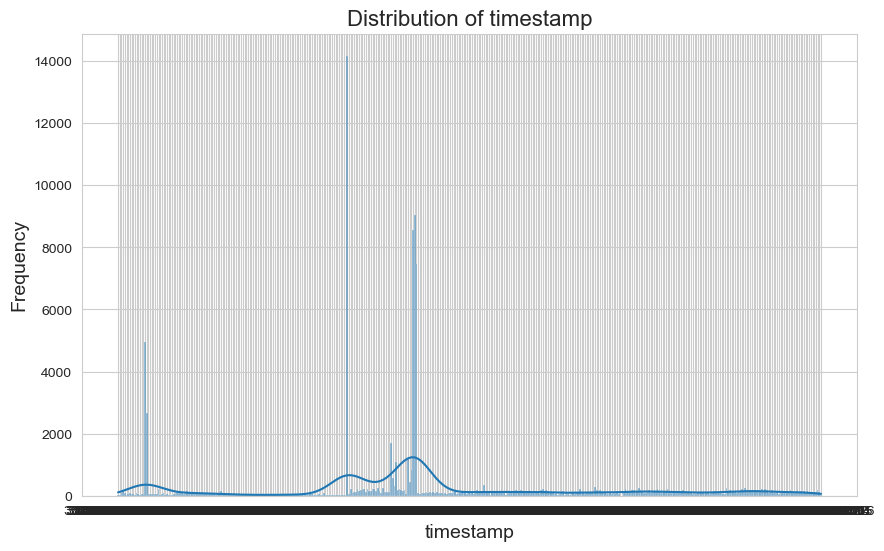

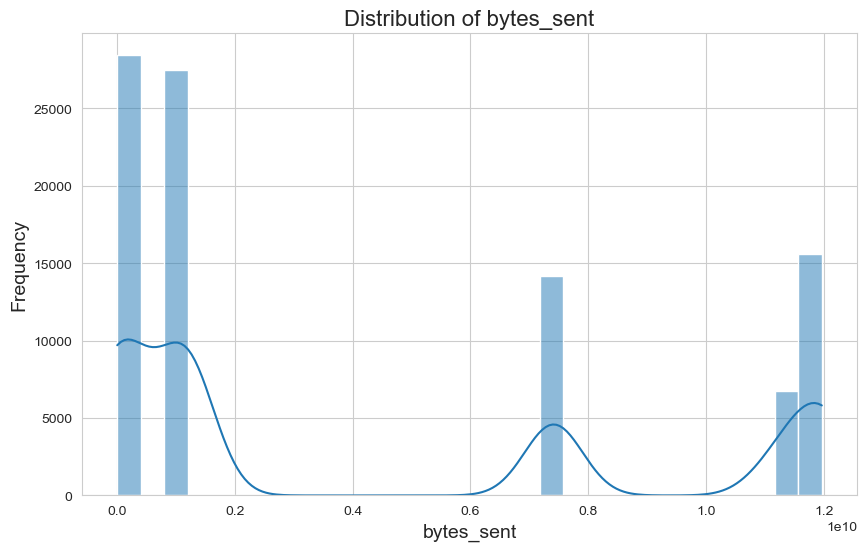

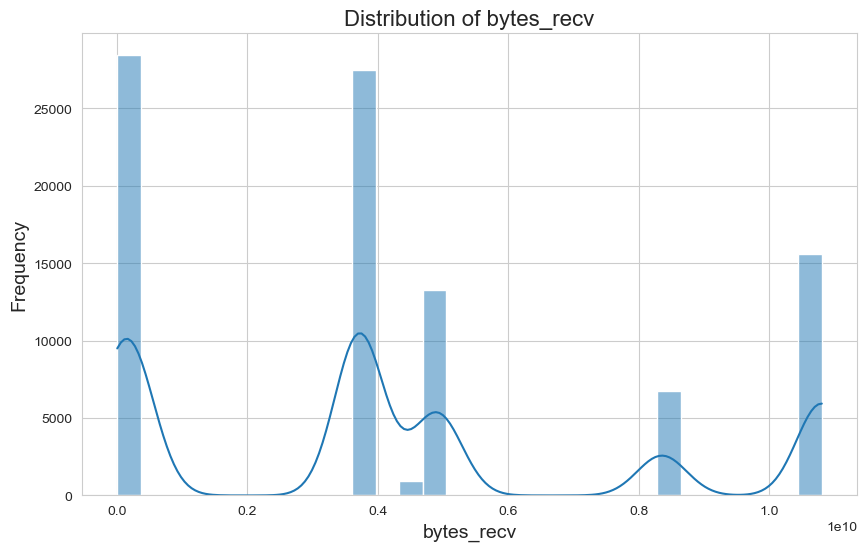

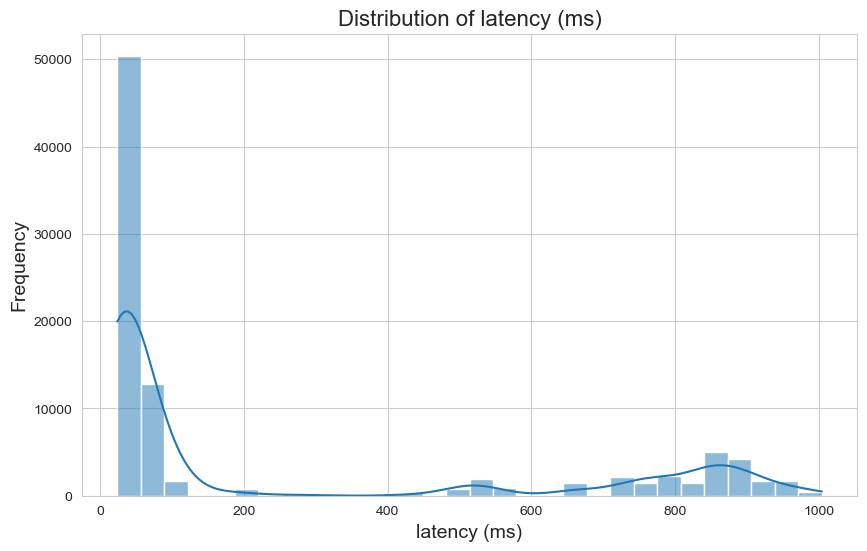

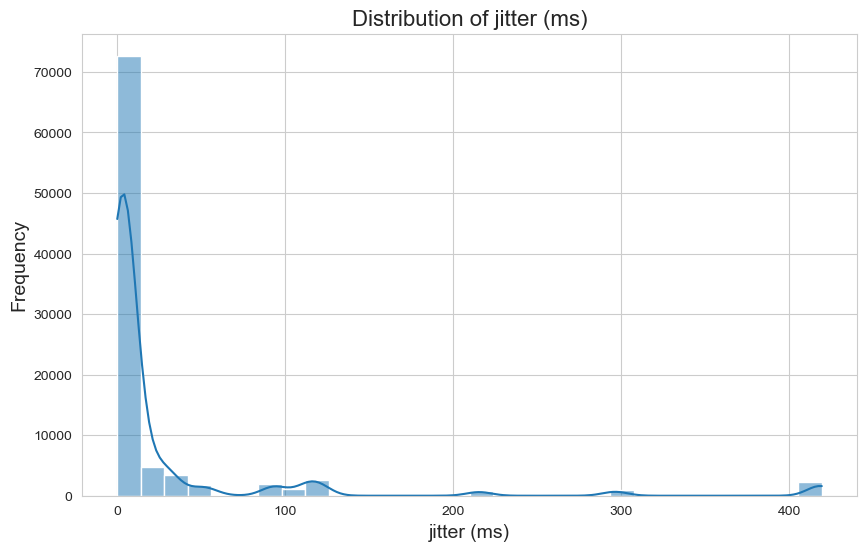

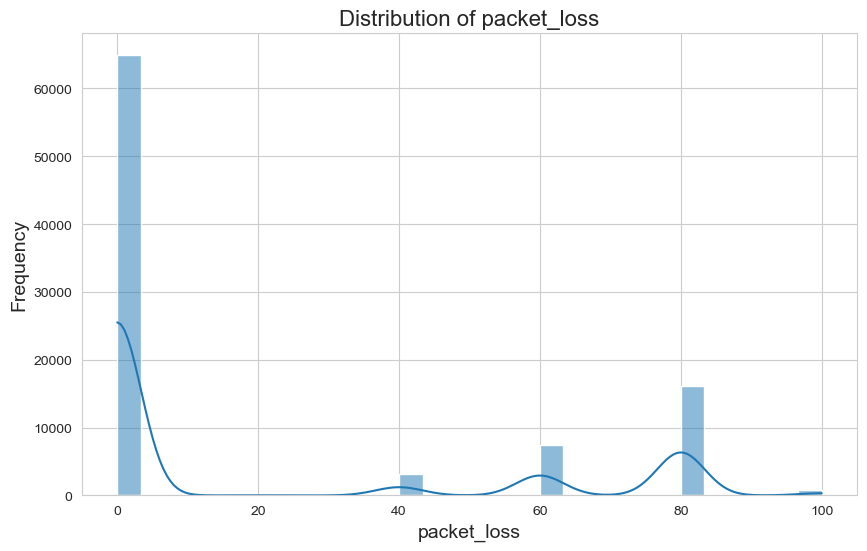

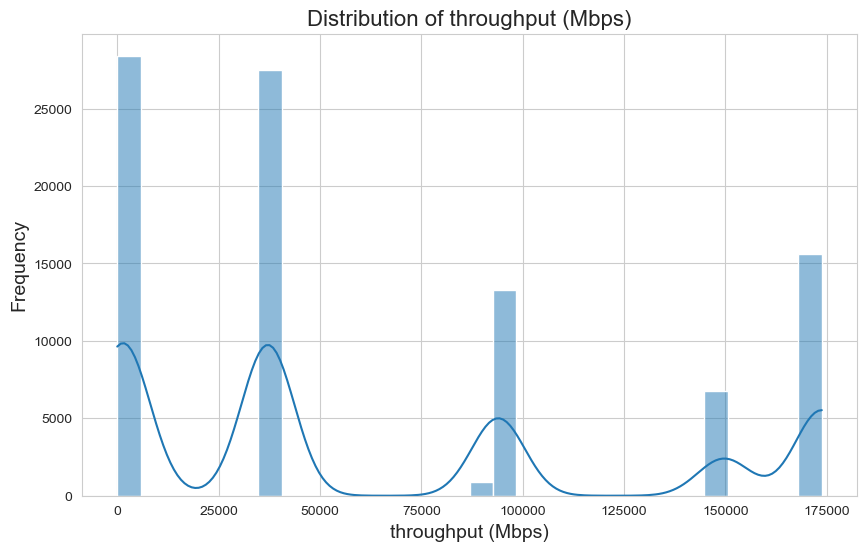

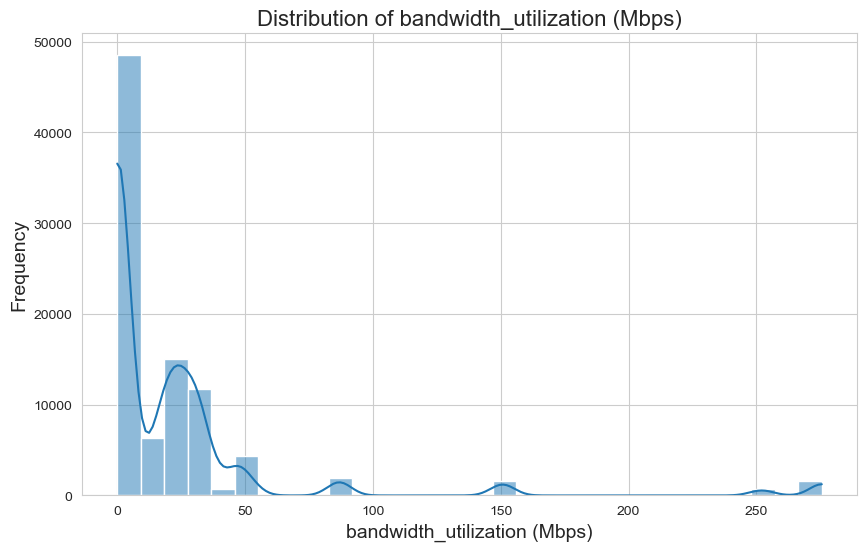

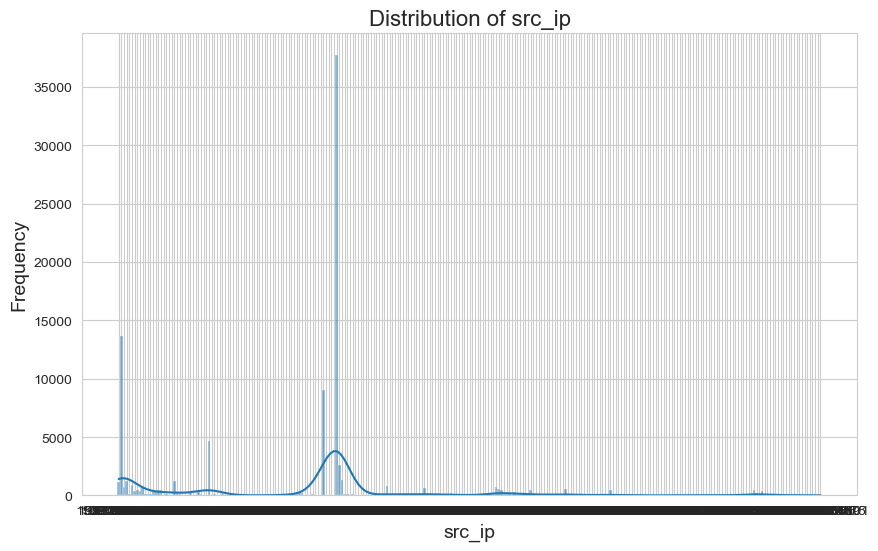

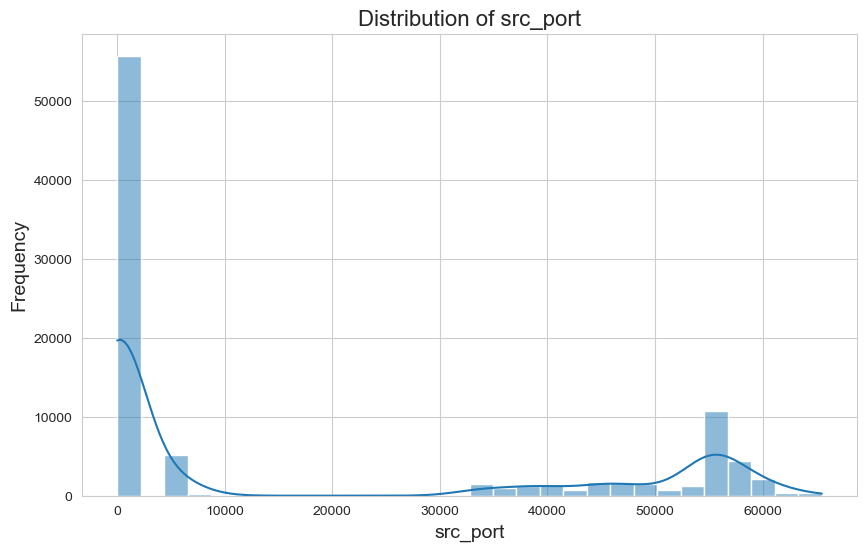

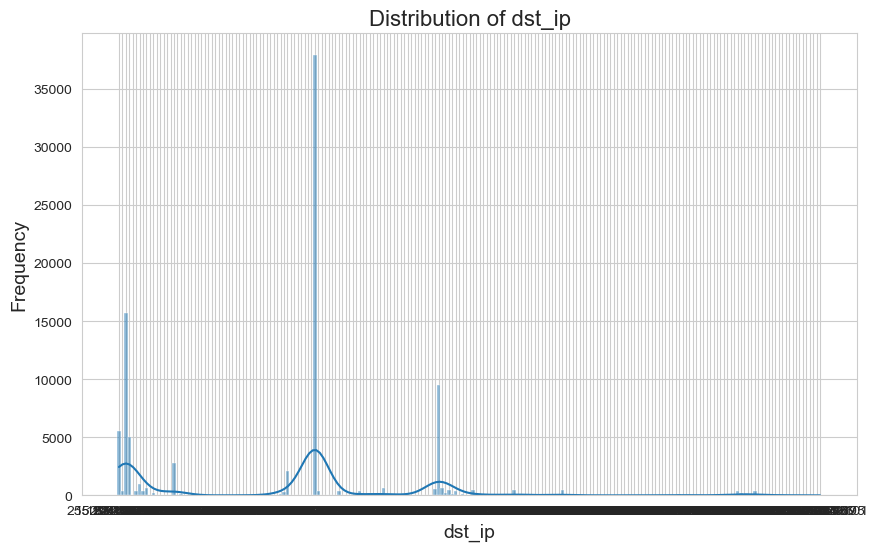

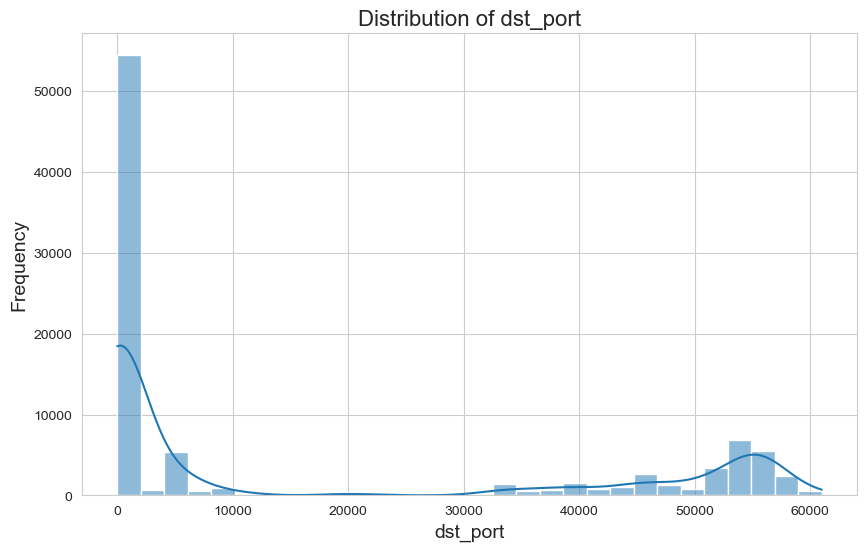

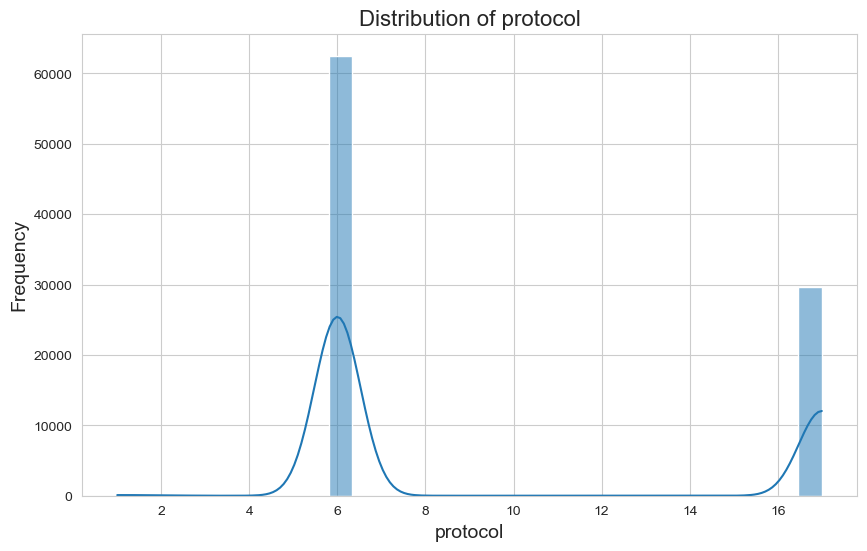

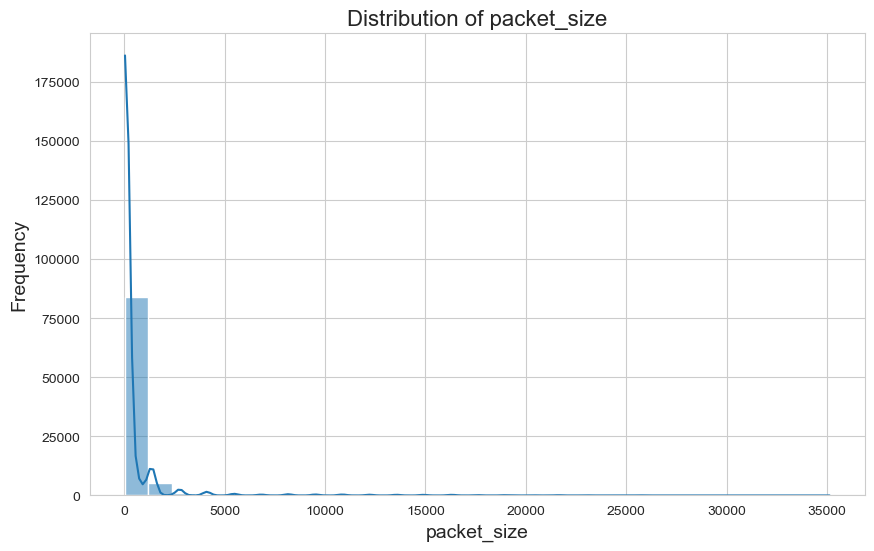

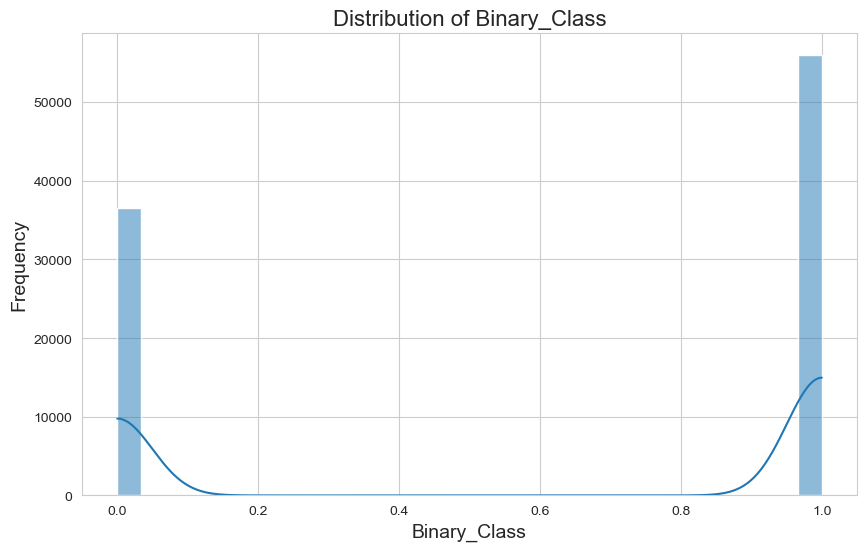

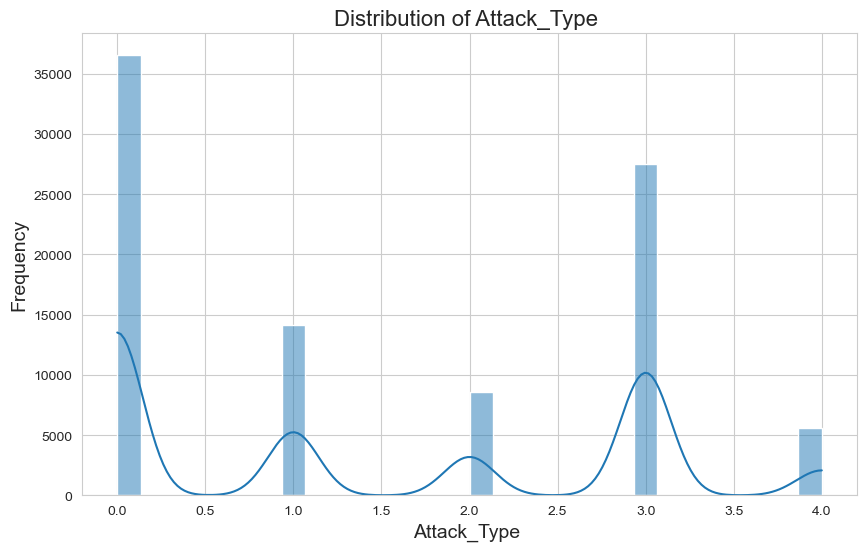

In [19]:


# Plot distributions for each feature
features = ['timestamp'	,'bytes_sent'	,'bytes_recv',	'latency (ms)'	,'jitter (ms)'	,'packet_loss',	'throughput (Mbps)',	'bandwidth_utilization (Mbps)',	'src_ip'	,'src_port',	'dst_ip'	,'dst_port',	'protocol',	'packet_size',	'Binary_Class',	'Attack_Type '  ]

for feature in features:
    plt.figure(figsize=(10, 6))
    sns.histplot(df[feature], kde=True, bins=30)
    plt.title(f'Distribution of {feature}', fontsize=16)
    plt.xlabel(feature, fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.show()

In [20]:
print(df.dtypes) 

timestamp                        object
bytes_sent                      float64
bytes_recv                      float64
latency (ms)                    float64
jitter (ms)                     float64
packet_loss                     float64
throughput (Mbps)               float64
bandwidth_utilization (Mbps)    float64
src_ip                           object
src_port                        float64
dst_ip                           object
dst_port                        float64
protocol                        float64
packet_size                     float64
Binary_Class                      int64
Attack_Type                       int64
dtype: object


In [21]:
# List of columns that should be numeric but are currently of type 'object'
numeric_columns = [
    'bytes_sent', 'bytes_recv', 'latency (ms)', 'jitter (ms)', 
    'packet_loss', 'throughput (Mbps)', 'bandwidth_utilization (Mbps)', 
    'src_port', 'dst_port', 'protocol'
]

# Convert these columns to numeric
for column in numeric_columns:
    df[column] = pd.to_numeric(df[column], errors='coerce')


print(df.dtypes) 

timestamp                        object
bytes_sent                      float64
bytes_recv                      float64
latency (ms)                    float64
jitter (ms)                     float64
packet_loss                     float64
throughput (Mbps)               float64
bandwidth_utilization (Mbps)    float64
src_ip                           object
src_port                        float64
dst_ip                           object
dst_port                        float64
protocol                        float64
packet_size                     float64
Binary_Class                      int64
Attack_Type                       int64
dtype: object


In [9]:
correlations = df[['bytes_sent', 'bytes_recv', 'latency (ms)', 'jitter (ms)', 
    'packet_loss', 'throughput (Mbps)', 'bandwidth_utilization (Mbps)', 
    'src_port', 'dst_port', 'protocol','Binary_Class','Attack_Type ' ]].corr()
print(correlations['Binary_Class'].sort_values(ascending=False))

Binary_Class                    1.000000
Attack_Type                     0.843360
packet_loss                     0.510922
latency (ms)                    0.509313
jitter (ms)                     0.200443
bandwidth_utilization (Mbps)   -0.091199
src_port                       -0.197791
dst_port                       -0.299326
protocol                       -0.410478
bytes_recv                     -0.810364
throughput (Mbps)              -0.908963
bytes_sent                     -0.956915
Name: Binary_Class, dtype: float64


In [11]:
# Calculate skewness for each numerical column
skewness_values = df.skew(numeric_only=True)

# Print skewness values
print("Skewness values for each numerical feature:")
print(skewness_values)

# Optional: Highlight highly skewed features
threshold = 1  # Define a threshold for identifying high skewness
highly_skewed = skewness_values[abs(skewness_values) > threshold]
print("\nHighly skewed features:")
print(highly_skewed)

Skewness values for each numerical feature:
bytes_sent                      0.615179
bytes_recv                      0.539496
latency (ms)                    1.092188
jitter (ms)                     4.103139
packet_loss                     1.047035
throughput (Mbps)               0.625381
bandwidth_utilization (Mbps)    4.024721
src_port                        0.793775
dst_port                        0.825689
protocol                        0.758990
packet_size                     8.584203
Binary_Class                   -0.429563
Attack_Type                     0.268392
dtype: float64

Highly skewed features:
latency (ms)                    1.092188
jitter (ms)                     4.103139
packet_loss                     1.047035
bandwidth_utilization (Mbps)    4.024721
packet_size                     8.584203
dtype: float64


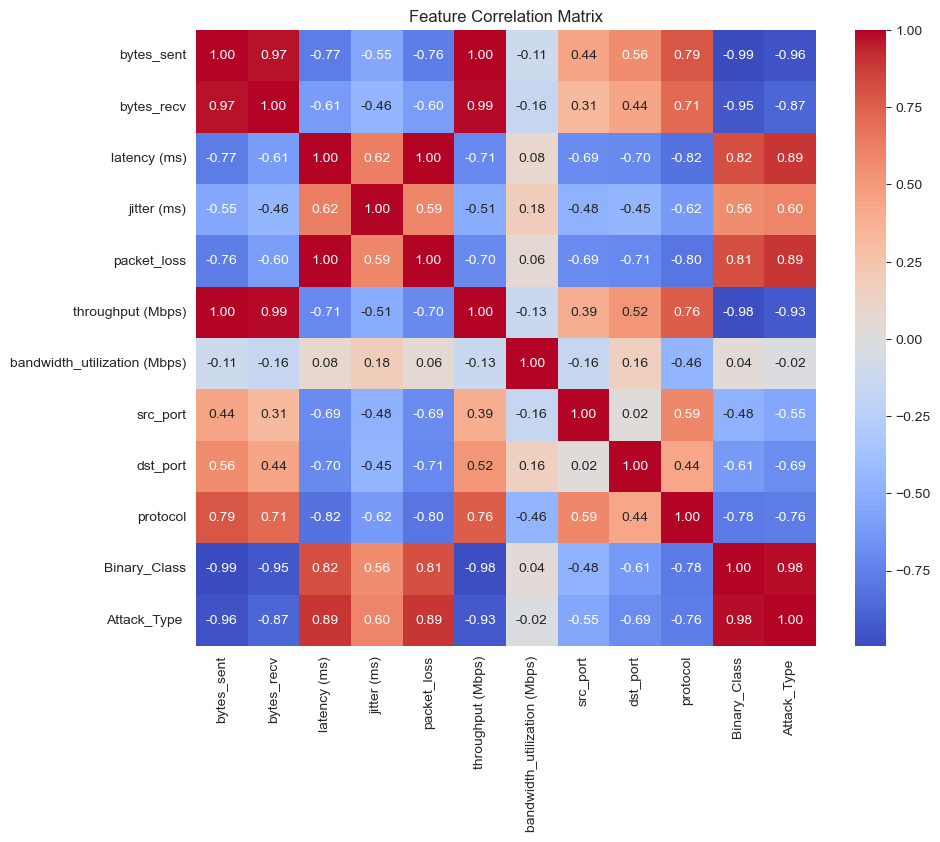

In [23]:
# Calculate correlation matrix
correlation_matrix = correlations.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()

In [24]:
df.columns = df.columns.str.strip()
# Drop columns that are not needed for the model
X = df.drop(columns=['timestamp', 'src_ip', 'dst_ip', 'Binary_Class', 'Attack_Type'], errors='ignore')
y_binary = df['Binary_Class']  # Binary target for Stage 1 (0 for normal, 1 for any attack)
print(X.columns)



Index(['bytes_sent', 'bytes_recv', 'latency (ms)', 'jitter (ms)',
       'packet_loss', 'throughput (Mbps)', 'bandwidth_utilization (Mbps)',
       'src_port', 'dst_port', 'protocol', 'packet_size'],
      dtype='object')


In [25]:
num_rows = len(df)

print("Number of rows:", num_rows)

Number of rows: 92419


In [26]:
print(X.isna().sum())  # This will show the number of NaN values in `X`
print(y_binary.isna().sum())  # This will show the number of NaN values in `y`

bytes_sent                        1
bytes_recv                        1
latency (ms)                    818
jitter (ms)                       1
packet_loss                       1
throughput (Mbps)                 1
bandwidth_utilization (Mbps)      1
src_port                        487
dst_port                        487
protocol                          1
packet_size                       1
dtype: int64
0


In [27]:
# Define columns for different imputation strategies
mode_columns = ['src_port', 'dst_port']
median_columns = ['bytes_sent', 'bytes_recv', 'latency (ms)', 'jitter (ms)',
                  'packet_loss', 'throughput (Mbps)', 'bandwidth_utilization (Mbps)',
                  'protocol', 'packet_size']

# Impute most frequent (mode) for categorical columns
mode_imputer = SimpleImputer(strategy='most_frequent')
df[mode_columns] = mode_imputer.fit_transform(df[mode_columns])

# Impute median for numerical columns
median_imputer = SimpleImputer(strategy='median')
df[median_columns] = median_imputer.fit_transform(df[median_columns])

# Check if missing values remain
print("Remaining missing values after imputation:")
print(df[mode_columns + median_columns].isna().sum())
print(df.columns)

Remaining missing values after imputation:
src_port                        0
dst_port                        0
bytes_sent                      0
bytes_recv                      0
latency (ms)                    0
jitter (ms)                     0
packet_loss                     0
throughput (Mbps)               0
bandwidth_utilization (Mbps)    0
protocol                        0
packet_size                     0
dtype: int64
Index(['timestamp', 'bytes_sent', 'bytes_recv', 'latency (ms)', 'jitter (ms)',
       'packet_loss', 'throughput (Mbps)', 'bandwidth_utilization (Mbps)',
       'src_ip', 'src_port', 'dst_ip', 'dst_port', 'protocol', 'packet_size',
       'Binary_Class', 'Attack_Type'],
      dtype='object')


## 1.Chi-Squared Feature Selection

In [29]:
from sklearn.feature_selection import SelectKBest, chi2
numerical_columns = ['bytes_sent', 'bytes_recv', 'latency (ms)', 'jitter (ms)', 
                     'packet_loss', 'throughput (Mbps)', 'bandwidth_utilization (Mbps)', 
                     'packet_size']
# Select K Best Features using Chi-Squared
X = df[numerical_columns]
y = df["Binary_Class"]

selector = SelectKBest(score_func=chi2, k=5)  # Select top 5 features
X_new = selector.fit_transform(X, y)

# Get the selected feature names
selected_features = selector.get_support(indices=True)
selected_feature_names = [numerical_columns[i] for i in selected_features]
print("Selected Features:", selected_feature_names)


Selected Features: ['bytes_sent', 'bytes_recv', 'latency (ms)', 'throughput (Mbps)', 'packet_size']


## 2.Grid Search for Hyperparameter Optimization

In [31]:
# Select features with strong correlation to the target
high_corr_features = correlation_matrix["Binary_Class"].abs().sort_values(ascending=False)
print("Highly Correlated Features:\n", high_corr_features)

Highly Correlated Features:
 Binary_Class                    1.000000
bytes_sent                      0.994036
throughput (Mbps)               0.981413
Attack_Type                     0.978939
bytes_recv                      0.947283
latency (ms)                    0.815342
packet_loss                     0.810987
protocol                        0.781991
dst_port                        0.612906
jitter (ms)                     0.563617
src_port                        0.476695
bandwidth_utilization (Mbps)    0.038152
Name: Binary_Class, dtype: float64


In [32]:
# Load the Dataset
data = pd.read_csv("Mixed_NormalAbnormal_Data-LastVersion-23-11-2024.csv", sep=";")  # Replace with the correct file path

# Preprocessing
# Strip column names and remove unnecessary spaces
data.columns = data.columns.str.strip()
numerical_columns = ['bytes_sent', 'bytes_recv', 'latency (ms)', 'jitter (ms)', 
                     'packet_loss', 'throughput (Mbps)', 'bandwidth_utilization (Mbps)', 
                     'packet_size']
# Drop irrelevant columns (adjust based on your dataset)
X = data.drop(columns=["timestamp", "src_ip", "dst_ip", "Binary_Class", "Attack_Type "], errors="ignore")
y_binary = data["Binary_Class"]  # Binary target for normal vs. abnormal classification



# Feature Scaling
scaler = StandardScaler()
X[numerical_columns] = scaler.fit_transform(X[numerical_columns])

In [33]:

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.3, stratify=y_binary, random_state=42)

# Model Training - Random Forest
grid_search = RandomForestClassifier(random_state=42)

# Hyperparameter Tuning
param_grid = {
    "n_estimators": [50, 100, 150],
    "max_depth": [5, 10, 15, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
}

random_search_rf = RandomizedSearchCV(
    grid_search, param_distributions=param_grid, n_iter=10, cv=5, scoring="accuracy", random_state=42
)

random_search_rf.fit(X_train, y_train)

# Best Parameters and Model
print("Best Parameters for Binary Classifier:", random_search_rf.best_params_)
best_model = random_search_rf.best_estimator_

# Evaluate the Model
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

print("Training Accuracy:", accuracy_score(y_train, y_pred_train))
print("Test Accuracy:", accuracy_score(y_test, y_pred_test))
print("\nClassification Report:\n", classification_report(y_test, y_pred_test))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_test))

# Feature Importance
import matplotlib.pyplot as plt
feature_importances = pd.Series(best_model.feature_importances_, index=X.columns).sort_values(ascending=False)
feature_importances.plot(kind="bar", figsize=(10, 5), title="Feature Importance for Binary Classification")
plt.show()

# Optional: Cross-Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(best_model, X, y_binary, cv=cv, scoring="accuracy")
print("Cross-Validation Accuracy Scores:", cv_scores)
print("Mean Cross-Validation Accuracy:", np.mean(cv_scores))

# SHAP for Feature Importance
import shap

# Fit the best model
best_model.fit(X_train, y_train)

# Explain predictions using SHAP
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

# Visualize feature importance
shap.summary_plot(shap_values, X_test, feature_names=X.columns)



NameError: name 'RandomizedSearchCV' is not defined

In [46]:
# Define the best model
best_model = RandomForestClassifier(random_state=42)

# Train the model
best_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

C:\Users\client\AppData\Local\Temp\ipykernel_10012\2230082323.py:21: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data["timestamp"] = pd.to_datetime(data["timestamp"], errors="coerce")
C:\Users\client\AppData\Local\Temp\ipykernel_10012\2230082323.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_binary, order=y_binary.value_counts().index, palette="viridis")


Class Distribution Before Balancing:
Binary_Class:
 Binary_Class
1    55761
0    36171
Name: count, dtype: int64
Attack_Type:
 Attack_Type
0    36171
3    27497
1    14170
2     8603
4     5491
Name: count, dtype: int64


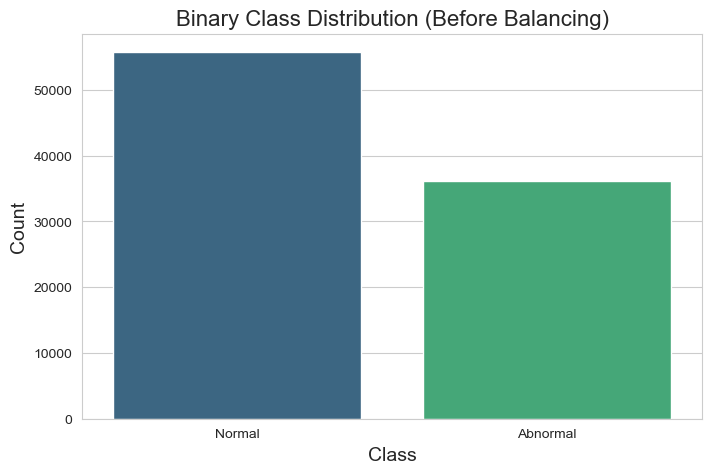

C:\Users\client\AppData\Local\Temp\ipykernel_10012\2230082323.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_attack_type, order=y_attack_type.value_counts().index, palette="viridis")


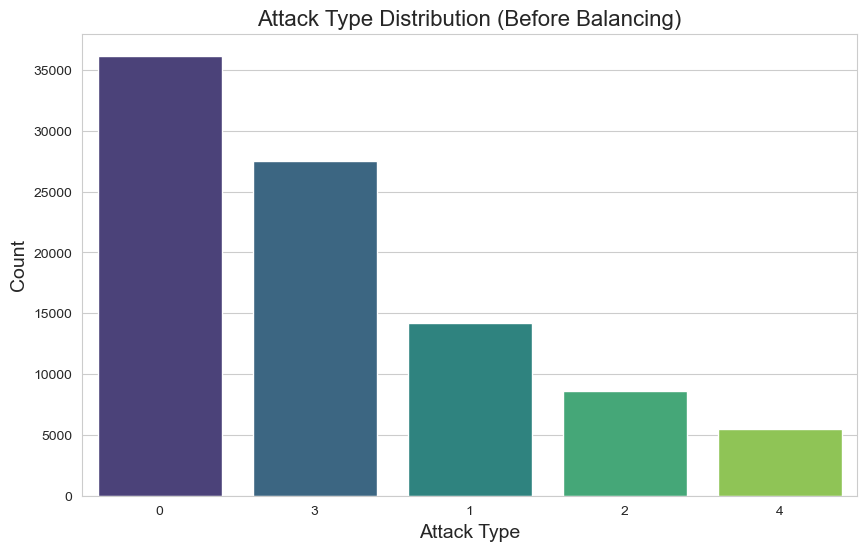

Class Distribution After Balancing:
Binary_Class:
 Binary_Class
0    55761
1    55761
Name: count, dtype: int64
Attack_Type:
 Attack_Type
0    36171
1    36171
2    36171
3    36171
4    36171
Name: count, dtype: int64


C:\Users\client\AppData\Local\Temp\ipykernel_10012\2230082323.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_balanced_binary, order=pd.Series(y_balanced_binary).value_counts().index, palette="viridis")


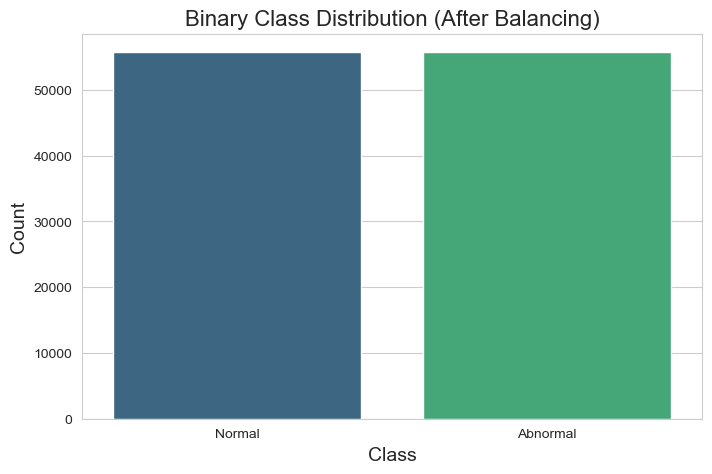

C:\Users\client\AppData\Local\Temp\ipykernel_10012\2230082323.py:96: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_balanced_attack, order=pd.Series(y_balanced_attack).value_counts().index, palette="viridis")


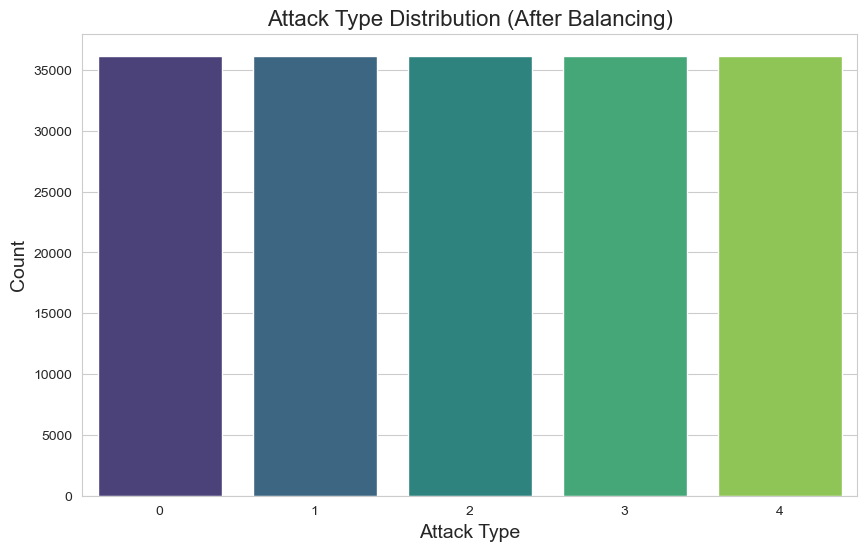

Selected Features: ['bytes_sent', 'bytes_recv', 'latency (ms)', 'packet_loss', 'throughput (Mbps)']
Binary Classification Accuracy: 1.0
Binary Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     16580
           1       1.00      1.00      1.00     16877

    accuracy                           1.00     33457
   macro avg       1.00      1.00      1.00     33457
weighted avg       1.00      1.00      1.00     33457

Binary Classification Confusion Matrix:
 [[16580     0]
 [    0 16877]]
Attack Type Classification Accuracy: 0.9992811987393332
Attack Type Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     10833
           1       1.00      1.00      1.00     10618
           2       1.00      1.00      1.00     10982
           3       1.00      1.00      1.00     10846
           4       1.00      1.00      1.00     10978

    accuracy    

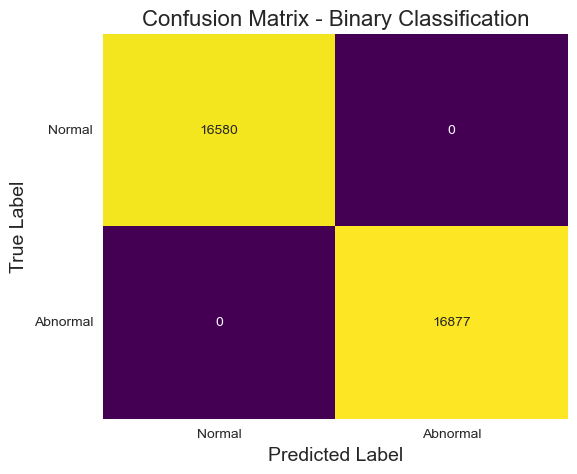

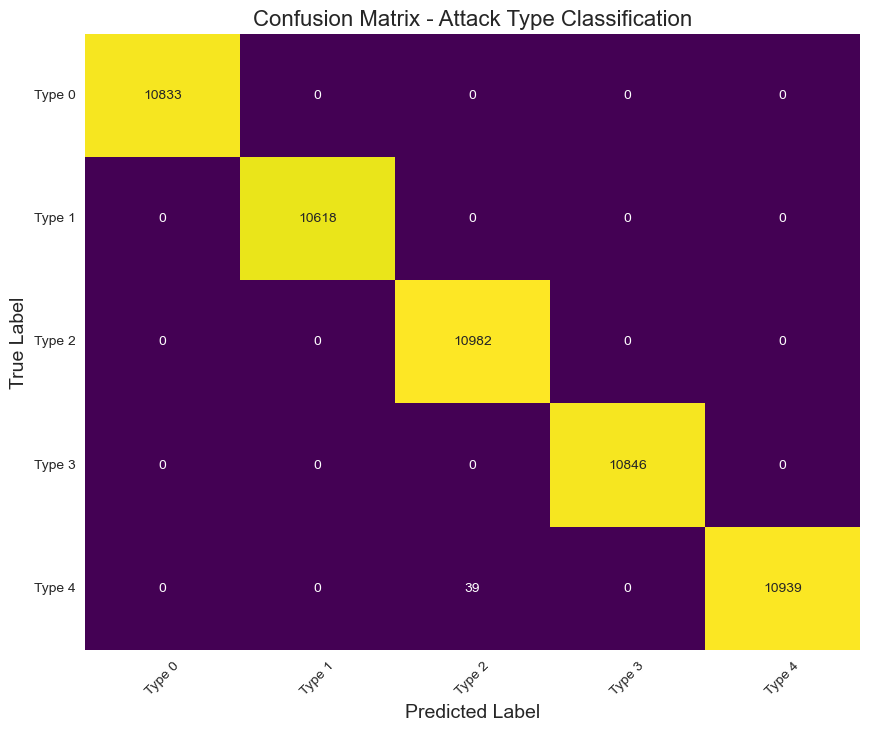

In [48]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from lime.lime_tabular import LimeTabularExplainer
import shap
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sns

# Load the Dataset
data = pd.read_csv("Mixed_NormalAbnormal_Data-LastVersion-23-11-2024.csv", sep=";")  # Replace with the correct file path

# Preprocessing
# Convert timestamps to datetime format
data["timestamp"] = pd.to_datetime(data["timestamp"], errors="coerce")

# Strip column names and remove unnecessary spaces
data.columns = data.columns.str.strip()

# Handle Missing Values
# Fill missing numerical values with the mean
numerical_columns = ['bytes_sent', 'bytes_recv', 'latency (ms)', 'jitter (ms)', 
                     'packet_loss', 'throughput (Mbps)', 'bandwidth_utilization (Mbps)', 
                     'packet_size']

for col in numerical_columns:
    if col in data.columns:
        data[col] = data[col].fillna(data[col].mean())

# Ensure no missing values remain
data = data.dropna()  # Drop any remaining rows with NaN values

# Drop irrelevant columns for feature selection
X = data[numerical_columns]
y_binary = data["Binary_Class"]  # Binary target for normal vs. abnormal classification
y_attack_type = data["Attack_Type"]  # Multi-class target for attack types

# Check class distributions before balancing
print("Class Distribution Before Balancing:")
print("Binary_Class:\n", y_binary.value_counts())
print("Attack_Type:\n", y_attack_type.value_counts())

# Visualize Distributions Before Balancing
# Binary Class Distribution
plt.figure(figsize=(8, 5))
sns.countplot(x=y_binary, order=y_binary.value_counts().index, palette="viridis")
plt.title("Binary Class Distribution (Before Balancing)", fontsize=16)
plt.xlabel("Class", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.xticks(ticks=[0, 1], labels=["Normal", "Abnormal"])
plt.show()

# Attack Type Distribution
plt.figure(figsize=(10, 6))
sns.countplot(x=y_attack_type, order=y_attack_type.value_counts().index, palette="viridis")
plt.title("Attack Type Distribution (Before Balancing)", fontsize=16)
plt.xlabel("Attack Type", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.show()

# Feature Scaling with MinMaxScaler (to ensure non-negative values for chi2)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Handle Class Imbalance for Binary_Class using SMOTE
smote_binary = SMOTE(random_state=42)
X_balanced_binary, y_balanced_binary = smote_binary.fit_resample(X_scaled, y_binary)

# Handle Class Imbalance for Attack_Type using SMOTE
smote_attack = SMOTE(random_state=42)
X_balanced_attack, y_balanced_attack = smote_attack.fit_resample(X_scaled, y_attack_type)

# Verify class distributions after balancing
print("Class Distribution After Balancing:")
print("Binary_Class:\n", pd.Series(y_balanced_binary).value_counts())
print("Attack_Type:\n", pd.Series(y_balanced_attack).value_counts())

# Visualize Distributions After Balancing
# Binary Class Distribution After Balancing
plt.figure(figsize=(8, 5))
sns.countplot(x=y_balanced_binary, order=pd.Series(y_balanced_binary).value_counts().index, palette="viridis")
plt.title("Binary Class Distribution (After Balancing)", fontsize=16)
plt.xlabel("Class", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.xticks(ticks=[0, 1], labels=["Normal", "Abnormal"])
plt.show()

# Attack Type Distribution After Balancing
plt.figure(figsize=(10, 6))
sns.countplot(x=y_balanced_attack, order=pd.Series(y_balanced_attack).value_counts().index, palette="viridis")
plt.title("Attack Type Distribution (After Balancing)", fontsize=16)
plt.xlabel("Attack Type", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.show()

# Feature Selection using Chi-Square
selector = SelectKBest(score_func=chi2, k=5)  # Select top 5 features
X_new = selector.fit_transform(X_balanced_binary, y_balanced_binary)  # Use binary classification for feature selection
selected_features = selector.get_support(indices=True)
selected_feature_names = [numerical_columns[i] for i in selected_features]
print("Selected Features:", selected_feature_names)

# Split Dataset for Binary Classification
X_train_binary, X_test_binary, y_train_binary, y_test_binary = train_test_split(
    X_new, y_balanced_binary, test_size=0.3, random_state=42
)

# Split Dataset for Attack Type Classification
X_train_attack, X_test_attack, y_train_attack, y_test_attack = train_test_split(
    X_balanced_attack, y_balanced_attack, test_size=0.3, random_state=42
)

# Train RandomForest for Binary Classification
rf_binary = RandomForestClassifier(random_state=42)
rf_binary.fit(X_train_binary, y_train_binary)
y_pred_binary = rf_binary.predict(X_test_binary)

# Evaluate Binary Classification Model
print("Binary Classification Accuracy:", accuracy_score(y_test_binary, y_pred_binary))
print("Binary Classification Report:\n", classification_report(y_test_binary, y_pred_binary))
print("Binary Classification Confusion Matrix:\n", confusion_matrix(y_test_binary, y_pred_binary))

# Train RandomForest for Attack Type Classification
rf_attack = RandomForestClassifier(random_state=42)
rf_attack.fit(X_train_attack, y_train_attack)
y_pred_attack = rf_attack.predict(X_test_attack)

# Evaluate Attack Type Classification Model
print("Attack Type Classification Accuracy:", accuracy_score(y_test_attack, y_pred_attack))
print("Attack Type Classification Report:\n", classification_report(y_test_attack, y_pred_attack))
print("Attack Type Classification Confusion Matrix:\n", confusion_matrix(y_test_attack, y_pred_attack))



# Plot Confusion Matrix for Binary Classification
binary_cm = confusion_matrix(y_test_binary, y_pred_binary)
plt.figure(figsize=(6, 5))
sns.heatmap(binary_cm, annot=True, fmt="d", cmap="viridis", cbar=False)
plt.title("Confusion Matrix - Binary Classification", fontsize=16)
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.xticks(ticks=[0.5, 1.5], labels=["Normal", "Abnormal"])
plt.yticks(ticks=[0.5, 1.5], labels=["Normal", "Abnormal"], rotation=0)
plt.show()

# Plot Confusion Matrix for Attack Type Classification
attack_cm = confusion_matrix(y_test_attack, y_pred_attack)
plt.figure(figsize=(10, 8))
sns.heatmap(attack_cm, annot=True, fmt="d", cmap="viridis", cbar=False)
plt.title("Confusion Matrix - Attack Type Classification", fontsize=16)
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.xticks(ticks=[0.5, 1.5, 2.5, 3.5, 4.5], labels=["Type 0", "Type 1", "Type 2", "Type 3", "Type 4"], rotation=45)
plt.yticks(ticks=[0.5, 1.5, 2.5, 3.5, 4.5], labels=["Type 0", "Type 1", "Type 2", "Type 3", "Type 4"], rotation=0)
plt.show()



In [49]:


grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)



# LIME for Explainability
lime_explainer = LimeTabularExplainer(
    training_data=X_train,
    feature_names=selected_feature_names,
    class_names=['Normal', 'Abnormal'],
    mode='classification'
)

# Explain a single instance
i = 0  # Index of the instance to explain
lime_exp = lime_explainer.explain_instance(
    data_row=X_test[i],
    predict_fn=best_model.predict_proba
)
lime_exp.show_in_notebook()





Best Parameters: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}


InvalidIndexError: (slice(None, None, None), 0)

Explained Variance Ratio: [9.67520673e-01 3.24793270e-02 9.05951710e-14 8.39507457e-16
 1.33898181e-16]
Cumulative Explained Variance: [0.96752067 1.         1.         1.         1.        ]


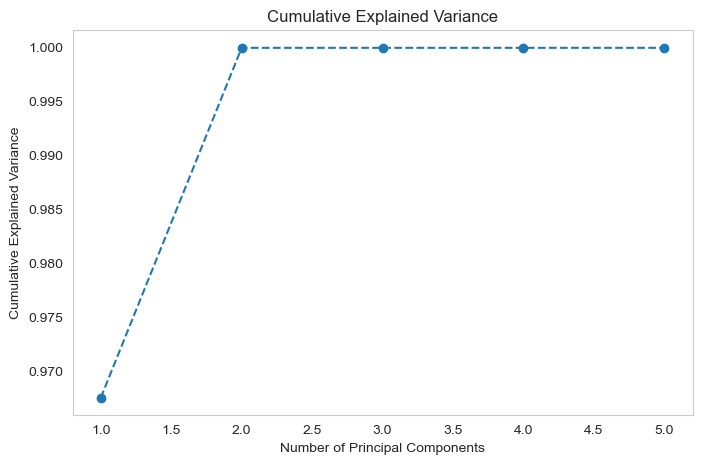

In [76]:
from sklearn.decomposition import PCA

pca = PCA(n_components=5)  # Adjust the number of components
X_reduced = pca.fit_transform(X)



# Explained variance by each principal component
explained_variance = pca.explained_variance_ratio_
print("Explained Variance Ratio:", explained_variance)

# Cumulative explained variance
cumulative_variance = explained_variance.cumsum()
print("Cumulative Explained Variance:", cumulative_variance)

# Plot cumulative explained variance
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()
plt.show()

C:\Users\client\AppData\Local\Temp\ipykernel_10012\4185522531.py:17: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data["timestamp"] = pd.to_datetime(data["timestamp"], errors="coerce")


Selected Features: ['bytes_sent', 'bytes_recv', 'latency (ms)', 'packet_loss', 'throughput (Mbps)']
Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}
Binary Classification Accuracy: 1.0
Binary Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     16580
           1       1.00      1.00      1.00     16877

    accuracy                           1.00     33457
   macro avg       1.00      1.00      1.00     33457
weighted avg       1.00      1.00      1.00     33457

Binary Classification Confusion Matrix:
 [[16580     0]
 [    0 16877]]


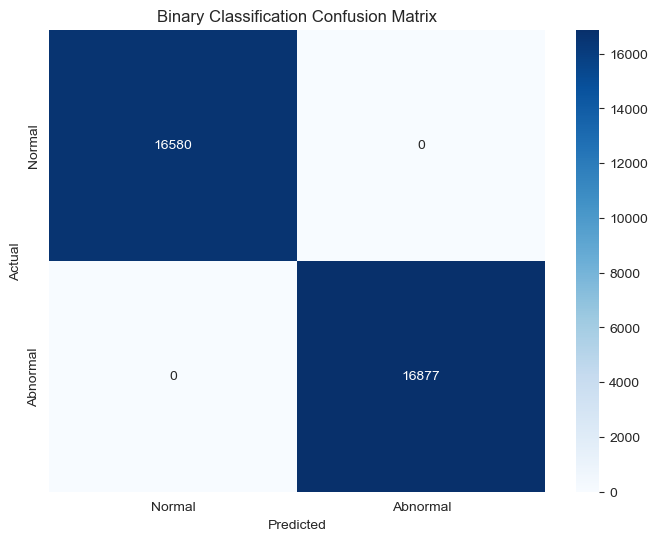

Cross-Validation Scores: [1. 1. 1. 1. 1.]
Mean Cross-Validation Accuracy: 1.0


In [78]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2

# Load the Dataset
data = pd.read_csv("Mixed_NormalAbnormal_Data-LastVersion-23-11-2024.csv", sep=";")  # Replace with your file path

# Preprocessing
data["timestamp"] = pd.to_datetime(data["timestamp"], errors="coerce")
data.columns = data.columns.str.strip()

# Handle Missing Values
numerical_columns = ['bytes_sent', 'bytes_recv', 'latency (ms)', 'jitter (ms)', 
                     'packet_loss', 'throughput (Mbps)', 'bandwidth_utilization (Mbps)', 
                     'packet_size']
for col in numerical_columns:
    if col in data.columns:
        data[col] = data[col].fillna(data[col].mean())

# Drop rows with remaining NaNs
data = data.dropna()

# Extract Features and Targets
X = data[numerical_columns]
y_binary = data["Binary_Class"]  # Binary target
y_attack_type = data["Attack_Type"]  # Multi-class target

# Feature Scaling with MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Handle Class Imbalance with SMOTE
smote_binary = SMOTE(random_state=42)
X_balanced_binary, y_balanced_binary = smote_binary.fit_resample(X_scaled, y_binary)

# Select Top Features Using Chi-Square
selector = SelectKBest(score_func=chi2, k=5)
X_selected = selector.fit_transform(X_balanced_binary, y_balanced_binary)
selected_features = selector.get_support(indices=True)
selected_feature_names = [numerical_columns[i] for i in selected_features]
print("Selected Features:", selected_feature_names)



X_selected = pd.DataFrame(X_selected, columns=selected_feature_names)

# Drop the 'bytes_sent' feature from the selected features
if 'bytes_sent' in X_selected.columns:
    X_selected = X_selected.drop(columns=['bytes_sent'])


# Split Dataset into Train and Test for Binary Classification
X_train, X_test, y_train, y_test = train_test_split(X_selected, y_balanced_binary, test_size=0.3, random_state=42)

# Cross-Validation and Grid Search for Hyperparameter Tuning
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}
rf_model = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best Model
best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# Evaluate the Model
y_pred = best_model.predict(X_test)
print("Binary Classification Accuracy:", accuracy_score(y_test, y_pred))
print("Binary Classification Report:\n", classification_report(y_test, y_pred))
print("Binary Classification Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Confusion Matrix Visualization
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Normal", "Abnormal"], yticklabels=["Normal", "Abnormal"])
plt.title("Binary Classification Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Evaluate with Cross-Validation
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5)
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean Cross-Validation Accuracy: {np.mean(cv_scores)}")

# Repeat Similar Process for Attack_Type Classification if Needed


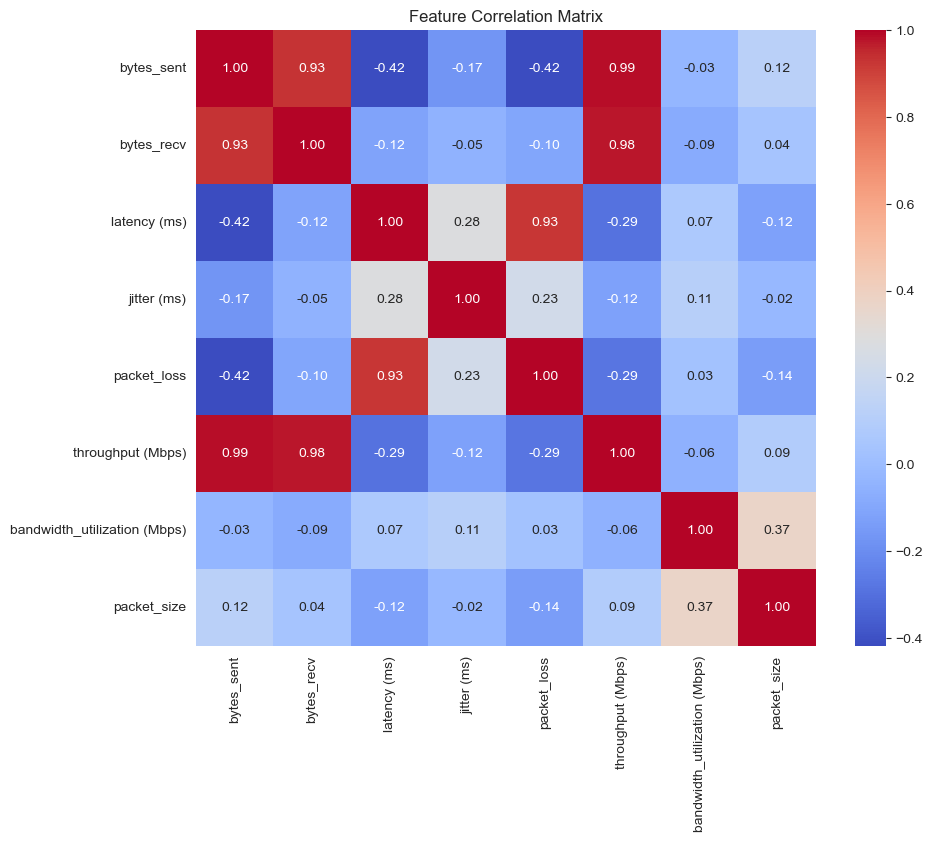

In [79]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate correlation matrix
correlation_matrix = X.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()


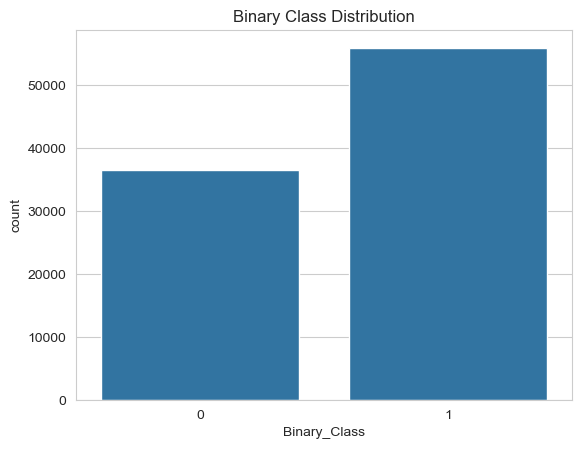

ValueError: Could not interpret value `Attack_Type ` for `x`. An entry with this name does not appear in `data`.

In [82]:
# Binary Class Distribution
sns.countplot(x='Binary_Class', data=df)
plt.title('Binary Class Distribution')
plt.show()

# Attack Type Distribution
sns.countplot(x='Attack_Type ', data=df)
plt.title('Attack Type Distribution')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Drop redundant features
#X = X.drop(columns=['bytes_sent', 'bytes_recv'], errors='ignore')


In [84]:
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA

# Ensure imputation is applied properly
categorical_columns = X.select_dtypes(include=["object"]).columns
numerical_columns = X.select_dtypes(include=["float64", "int64"]).columns

# Impute missing values
if not categorical_columns.empty:
    X[categorical_columns] = SimpleImputer(strategy="most_frequent").fit_transform(X[categorical_columns])

if not numerical_columns.empty:
    X[numerical_columns] = SimpleImputer(strategy="median").fit_transform(X[numerical_columns])

# Double-check for any remaining missing values
print("Remaining missing values:\n", X.isna().sum())  # Should print 0 for all columns

# Apply PCA
pca = PCA(n_components=5)
X_reduced = pca.fit_transform(X)


Remaining missing values:
 bytes_sent                      0
bytes_recv                      0
latency (ms)                    0
jitter (ms)                     0
packet_loss                     0
throughput (Mbps)               0
bandwidth_utilization (Mbps)    0
packet_size                     0
dtype: int64


C:\Users\client\AppData\Local\Temp\ipykernel_10012\4160313964.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[numerical_columns] = SimpleImputer(strategy="median").fit_transform(X[numerical_columns])


In [88]:
from sklearn.decomposition import PCA

pca = PCA(n_components=5)  # Adjust the number of components
X_reduced = pca.fit_transform(X)


Explained Variance Ratio: [9.67520673e-01 3.24793270e-02 9.05951710e-14 8.39507457e-16
 1.33898181e-16]
Cumulative Explained Variance: [0.96752067 1.         1.         1.         1.        ]


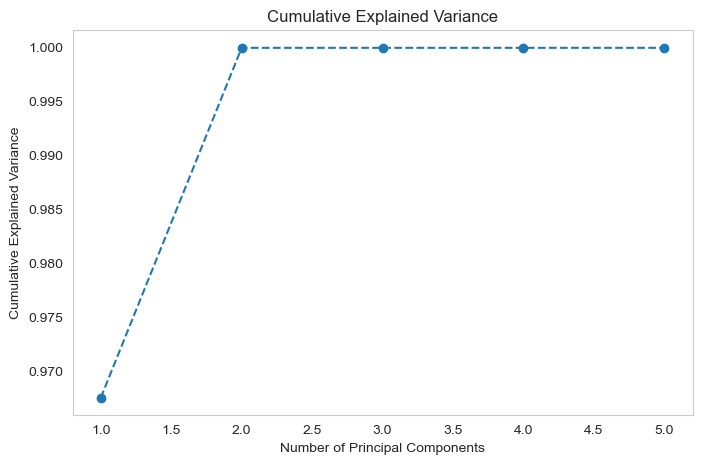

In [90]:
# Explained variance by each principal component
explained_variance = pca.explained_variance_ratio_
print("Explained Variance Ratio:", explained_variance)

# Cumulative explained variance
cumulative_variance = explained_variance.cumsum()
print("Cumulative Explained Variance:", cumulative_variance)

# Plot cumulative explained variance
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()
plt.show()


Accuracy: 0.9845540246555475
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98     10851
           1       0.99      0.98      0.99     16729

    accuracy                           0.98     27580
   macro avg       0.98      0.98      0.98     27580
weighted avg       0.98      0.98      0.98     27580

Confusion Matrix:
 [[10698   153]
 [  273 16456]]


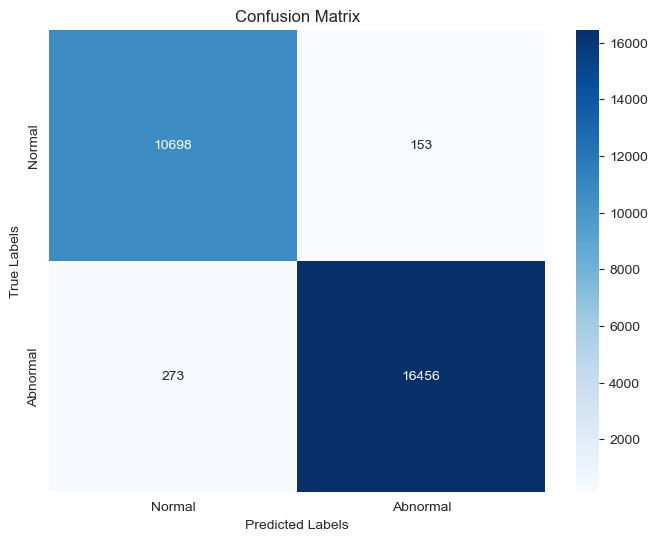

In [146]:
# Train-Test Split for reduced data
from sklearn.model_selection import train_test_split
X = X.drop(columns=[ 'bytes_recv' ], errors='ignore')
X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.3, stratify=y_binary, random_state=42)

# Train a Random Forest on the reduced data
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

grid_search = RandomForestClassifier(random_state=42)
grid_search.fit(X_train, y_train)

# Predictions
y_pred = grid_search.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Abnormal'], yticklabels=['Normal', 'Abnormal'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [252]:
# Split binary classification data
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(X_binary, y_binary, test_size=0.2, random_state=42, stratify=y_binary)

# Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_bin, y_train_bin = smote.fit_resample(X_train_bin, y_train_bin)

# Binary classification pipeline
binary_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(random_state=42, max_depth=10, n_estimators=50))
])

# Cross-validation
cv_scores_bin = cross_val_score(binary_pipeline, X_train_bin, y_train_bin, cv=5)
print("Binary Cross-Validation Scores:", cv_scores_bin)
print("Binary Cross-Validation Mean Score:", np.mean(cv_scores_bin))

# Train binary classifier
binary_pipeline.fit(X_train_bin, y_train_bin)

# Evaluate binary classifier
y_pred_bin = binary_pipeline.predict(X_test_bin)
print("Binary Classification Report:")
print(classification_report(y_test_bin, y_pred_bin))
print("Confusion Matrix:")
print(confusion_matrix(y_test_bin, y_pred_bin))

# Split multiclass classification data
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(X_multiclass, y_multiclass, test_size=0.2, random_state=42, stratify=y_multiclass)

# Multiclass classification pipeline
multiclass_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(random_state=42, max_depth=10, n_estimators=50))
])

# Cross-validation
cv_scores_multi = cross_val_score(multiclass_pipeline, X_train_multi, y_train_multi, cv=5)
print("Multiclass Cross-Validation Scores:", cv_scores_multi)
print("Multiclass Cross-Validation Mean Score:", np.mean(cv_scores_multi))

# Train multiclass classifier
multiclass_pipeline.fit(X_train_multi, y_train_multi)

# Evaluate multiclass classifier
y_pred_multi = multiclass_pipeline.predict(X_test_multi)
print("Multiclass Classification Report:")
print(classification_report(y_test_multi, y_pred_multi))
print("Confusion Matrix:")
print(confusion_matrix(y_test_multi, y_pred_multi))


Binary Cross-Validation Scores: [0.94315895 0.94109099 0.94561815 0.94584172 0.94192935]
Binary Cross-Validation Mean Score: 0.9435278336686788
Binary Classification Report:
              precision    recall  f1-score   support

           0       0.86      1.00      0.92      7301
           1       1.00      0.89      0.94     11183

    accuracy                           0.93     18484
   macro avg       0.93      0.94      0.93     18484
weighted avg       0.94      0.93      0.93     18484

Confusion Matrix:
[[7265   36]
 [1190 9993]]
Multiclass Cross-Validation Scores: [0.91350511 0.91458714 0.91634544 0.91959153 0.91140867]
Multiclass Cross-Validation Mean Score: 0.9150875769256779
Multiclass Classification Report:
              precision    recall  f1-score   support

           0       0.84      1.00      0.91      7301
           1       1.00      1.00      1.00      2834
           2       0.95      0.56      0.70      1725
           3       1.00      1.00      1.00      55

C:\Users\client\AppData\Local\Temp\ipykernel_10012\3262198771.py:13: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")  # Handle timestamp
C:\Users\client\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [02:07:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Binary Classification Accuracy (XGBoost): 0.9672392032047412
Binary Classification Report (XGBoost):
               precision    recall  f1-score   support

           0       0.94      0.98      0.96      7234
           1       0.99      0.96      0.97     10989

    accuracy                           0.97     18223
   macro avg       0.96      0.97      0.97     18223
weighted avg       0.97      0.97      0.97     18223

Binary Classification Confusion Matrix (XGBoost):
 [[ 7094   140]
 [  457 10532]]


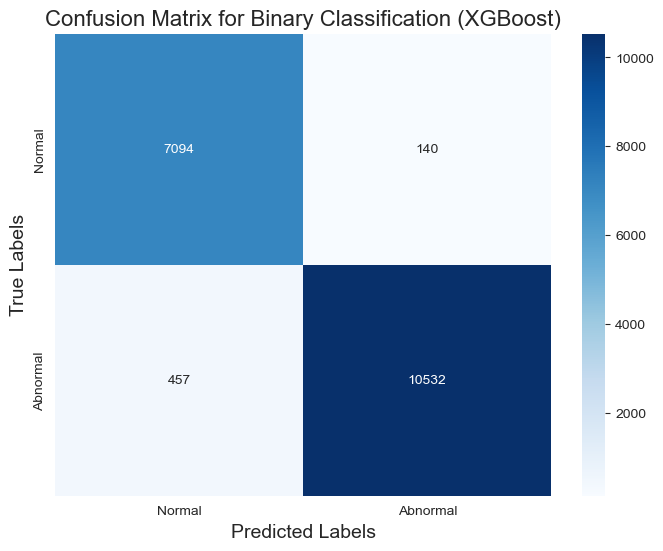

Multiclass Classification Report (XGBoost):


ValueError: Number of classes, 5, does not match size of target_names, 4. Try specifying the labels parameter

In [264]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

# Step 1: Load and Preprocess the Dataset
df = pd.read_csv("Mixed_NormalAbnormal_Data-LastVersion-23-11-2024.csv", sep=";")
df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")  # Handle timestamp
df.dropna(inplace=True)  # Remove rows with missing values

# Selected features for binary and multiclass classification
selected_features = ['packet_loss', 'latency (ms)', 'jitter (ms)', 'src_port', 'protocol']

# Binary classification target
X_binary = df[selected_features]
y_binary = df['Binary_Class']

# Multiclass classification target
X_multiclass = df[selected_features]
y_multiclass = df['Attack_Type ']

# Step 2: Binary Classification
# Train-Test Split for Binary Classification
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(
    X_binary, y_binary, test_size=0.2, random_state=42, stratify=y_binary
)

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train_bin, y_train_bin = smote.fit_resample(X_train_bin, y_train_bin)

# Standardize the data
scaler_bin = StandardScaler()
X_train_bin = scaler_bin.fit_transform(X_train_bin)
X_test_bin = scaler_bin.transform(X_test_bin)

# Initialize and train XGBoost for binary classification
xgb_bin = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric="logloss")
xgb_bin.fit(X_train_bin, y_train_bin)

# Predictions and evaluation for binary classification
y_pred_bin = xgb_bin.predict(X_test_bin)
print("Binary Classification Accuracy (XGBoost):", accuracy_score(y_test_bin, y_pred_bin))
print("Binary Classification Report (XGBoost):\n", classification_report(y_test_bin, y_pred_bin))
print("Binary Classification Confusion Matrix (XGBoost):\n", confusion_matrix(y_test_bin, y_pred_bin))

# Visualize Confusion Matrix for Binary Classification
conf_matrix_bin = confusion_matrix(y_test_bin, y_pred_bin)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_bin, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Abnormal'], yticklabels=['Normal', 'Abnormal'])
plt.title('Confusion Matrix for Binary Classification (XGBoost)', fontsize=16)
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.show()

# Step 3: Multiclass Classification
# Train-Test Split for Multiclass Classification
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(
    X_multiclass, y_multiclass, test_size=0.2, random_state=42, stratify=y_multiclass
)

# Handle class imbalance for multiclass classification
X_train_multi, y_train_multi = smote.fit_resample(X_train_multi, y_train_multi)

# Standardize the data
scaler_multi = StandardScaler()
X_train_multi = scaler_multi.fit_transform(X_train_multi)
X_test_multi = scaler_multi.transform(X_test_multi)

# Initialize and train XGBoost for multiclass classification
xgb_multi = XGBClassifier(objective="multi:softmax", num_class=4, random_state=42, eval_metric="mlogloss")
xgb_multi.fit(X_train_multi, y_train_multi)

# Predictions and evaluation for multiclass classification
y_pred_multi = xgb_multi.predict(X_test_multi)

# Unique class names for multiclass classification
target_names = ['DDoS', 'Brute Force', 'Spoofing', 'MITM']

# Classification Report
print("Multiclass Classification Report (XGBoost):")
print(classification_report(y_test_multi, y_pred_multi, target_names=target_names))

# Confusion Matrix
conf_matrix_xgb_multi = confusion_matrix(y_test_multi, y_pred_multi)

# Visualization of Confusion Matrix for Multiclass Classification
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_xgb_multi, annot=True, fmt='d', cmap='YlOrBr', 
            xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix for Multi-Class Classification (XGBoost)', fontsize=16)
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.show()

# Debugging Information for Classes
print("Unique classes in y_test_multi:", np.unique(y_test_multi))
print("Target names provided:", target_names)



In [94]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

random_search = RandomizedSearchCV(grid_search, param_distributions=param_grid, n_iter=10, cv=5, scoring='accuracy', random_state=42)
random_search.fit(X_train, y_train)

print("Best Parameters:", random_search.best_params_)
best_model = random_search.best_estimator_


Best Parameters: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 20}


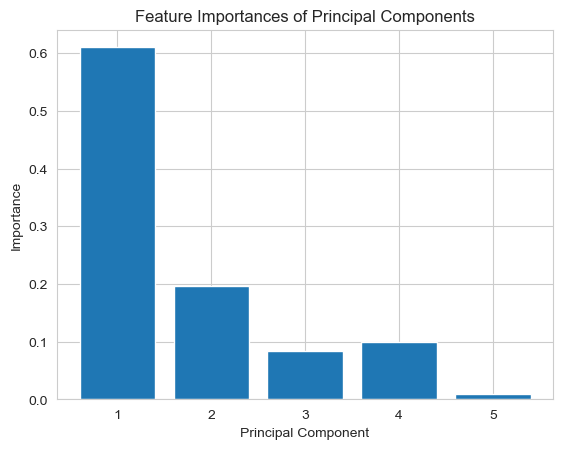

In [95]:
import numpy as np

# Feature importance for principal components
feature_importances = best_model.feature_importances_
plt.bar(range(1, len(feature_importances)+1), feature_importances)
plt.title('Feature Importances of Principal Components')
plt.xlabel('Principal Component')
plt.ylabel('Importance')
plt.show()


In [96]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(best_model, X_reduced, y_binary, cv=5, scoring="accuracy")
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Accuracy:", np.mean(cv_scores))


Cross-Validation Scores: [1. 1. 1. 1. 1.]
Mean CV Accuracy: 1.0


In [97]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [90, 100, 110],
    'max_depth': [10, 15, 20],
    'min_samples_split': [2, 3],
    'min_samples_leaf': [1, 2]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
print("Best Parameters from Grid Search:", grid_search.best_params_)


Best Parameters from Grid Search: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 90}


In [98]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'n_estimators': [50, 100, 150],
    'max_depth': [10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

# Perform RandomizedSearchCV with 20 iterations
random_search = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),
    param_distributions=param_dist,
    n_iter=20,  # Number of combinations to try
    cv=5,
    scoring="accuracy",
    random_state=42,
    n_jobs=-1  # Utilize all CPU cores
)
random_search.fit(X_train, y_train)

print("Best Parameters:", random_search.best_params_)


Best Parameters: {'n_estimators': 150, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 20}


In [99]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

# Predictions
y_pred_test = grid_search.best_estimator_.predict(X_test)

# Evaluation Metrics
print("Accuracy on Test Data:", accuracy_score(y_test, y_pred_test))
print("Classification Report:\n", classification_report(y_test, y_pred_test))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_test))

# If you have probabilities for ROC-AUC
y_prob_test = grid_search.best_estimator_.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_prob_test)
print("ROC-AUC Score:", roc_auc)


Accuracy on Test Data: 1.0
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     10851
           1       1.00      1.00      1.00     16729

    accuracy                           1.00     27580
   macro avg       1.00      1.00      1.00     27580
weighted avg       1.00      1.00      1.00     27580

Confusion Matrix:
 [[10851     0]
 [    0 16729]]
ROC-AUC Score: 1.0


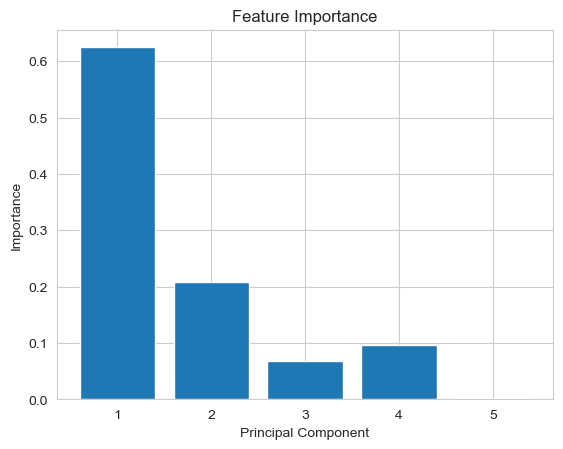

In [100]:
import matplotlib.pyplot as plt
import numpy as np

# If you are using the reduced dataset (PCA applied)
feature_importances = grid_search.best_estimator_.feature_importances_
plt.bar(range(1, len(feature_importances) + 1), feature_importances)
plt.xlabel('Principal Component')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.show()


In [ ]:
#****************************************************************************************************************

In [108]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score, train_test_split
import numpy as np
# Cross-Validation with Stratified ShuffleSplit
print(X.columns)
grid_search = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
cv_scores = cross_val_score(grid_search, X, y_binary, cv=cv, scoring='accuracy')

print("Cross-Validation Accuracy Scores:", cv_scores)
print("Mean Cross-Validation Accuracy:", np.mean(cv_scores))
print("Standard Deviation of CV Accuracy:", np.std(cv_scores))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.2, random_state=42)

# Initialize and train the Random Forest model

grid_search.fit(X_train, y_train)

# Evaluate model on test data
y_pred = grid_search.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Optionally, check for overfitting by evaluating on training data as well
y_train_pred = grid_search.predict(X_train)
print("Training Accuracy:", accuracy_score(y_train, y_train_pred))


Index(['bytes_sent', 'bytes_recv', 'latency (ms)', 'jitter (ms)',
       'packet_loss', 'throughput (Mbps)', 'bandwidth_utilization (Mbps)',
       'packet_size'],
      dtype='object')
Cross-Validation Accuracy Scores: [1. 1. 1. 1. 1.]
Mean Cross-Validation Accuracy: 1.0
Standard Deviation of CV Accuracy: 0.0
Test Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      7130
           1       1.00      1.00      1.00     11257

    accuracy                           1.00     18387
   macro avg       1.00      1.00      1.00     18387
weighted avg       1.00      1.00      1.00     18387

Confusion Matrix:
 [[ 7130     0]
 [    0 11257]]
Training Accuracy: 1.0


In [109]:
# Re-run cross-validation
cv_scores_reduced = cross_val_score(grid_search, X, y_binary, cv=cv, scoring='accuracy')
print("Cross-Validation Accuracy with Reduced Features:", cv_scores_reduced)
print("Mean CV Accuracy with Reduced Features:", np.mean(cv_scores_reduced))

Cross-Validation Accuracy with Reduced Features: [1. 1. 1. 1. 1.]
Mean CV Accuracy with Reduced Features: 1.0


In [111]:
X_reduced_further = X.drop(columns=['bandwidth_utilization (Mbps)'])
cv_scores_further_reduced = cross_val_score(grid_search, X_reduced_further, y_binary, cv=cv, scoring='accuracy')
print("Cross-Validation Accuracy with Further Reduced Features:", cv_scores_further_reduced)
print("Mean CV Accuracy with Further Reduced Features:", np.mean(cv_scores_further_reduced))

Cross-Validation Accuracy with Further Reduced Features: [1. 1. 1. 1. 1.]
Mean CV Accuracy with Further Reduced Features: 1.0


In [112]:
y_shuffled = np.random.permutation(y_binary)
cv_scores_shuffled = cross_val_score(grid_search, X_reduced_further, y_shuffled, cv=cv, scoring='accuracy')
print("Cross-Validation Accuracy with Shuffled Labels:", cv_scores_shuffled)
print("Mean CV Accuracy with Shuffled Labels:", np.mean(cv_scores_shuffled))

Cross-Validation Accuracy with Shuffled Labels: [0.60624354 0.60553652 0.60515582 0.6064067  0.60548213]
Mean CV Accuracy with Shuffled Labels: 0.6057649426225049


In [114]:
print(df.dtypes)

timestamp                        object
bytes_sent                      float64
bytes_recv                      float64
latency (ms)                    float64
jitter (ms)                     float64
packet_loss                     float64
throughput (Mbps)               float64
bandwidth_utilization (Mbps)    float64
src_ip                           object
src_port                        float64
dst_ip                           object
dst_port                        float64
protocol                        float64
packet_size                     float64
Binary_Class                      int64
Attack_Type                       int64
dtype: object


timestamp                        object
bytes_sent                      float64
bytes_recv                      float64
latency (ms)                    float64
jitter (ms)                     float64
packet_loss                     float64
throughput (Mbps)               float64
bandwidth_utilization (Mbps)    float64
src_ip                           object
src_port                        float64
dst_ip                           object
dst_port                        float64
protocol                        float64
packet_size                     float64
Binary_Class                      int64
Attack_Type                       int64
dtype: object
Index(['timestamp', 'bytes_sent', 'bytes_recv', 'latency (ms)', 'jitter (ms)',
       'packet_loss', 'throughput (Mbps)', 'bandwidth_utilization (Mbps)',
       'src_ip', 'src_port', 'dst_ip', 'dst_port', 'protocol', 'packet_size',
       'Binary_Class', 'Attack_Type'],
      dtype='object')
X_attack EAFTER DELETING THE FEATURES:***************

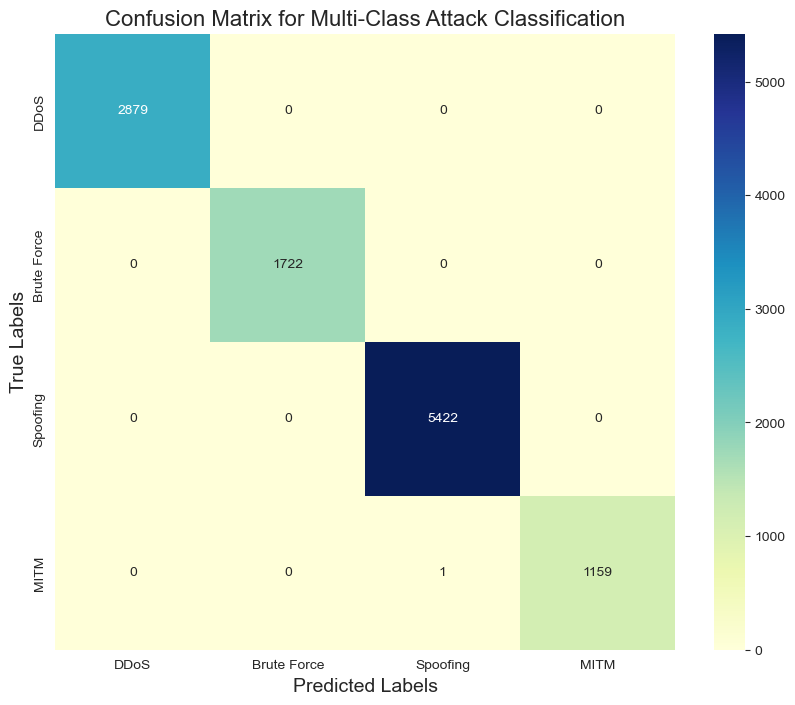

In [200]:
# Step 2: Filter the attacks •  Normal traffic = 0 •  DDoS = 1 •  Brute Force = 2 •  Spoofing = 3 •  MITM = 4

# Step 2.1: Filter the attack data
attack_data = df[df['Binary_Class'] == 1]  # Use only the rows classified as attacks in Stage 1
print(attack_data.dtypes)
# Double-check for any spaces or hidden characters
attack_data.columns = attack_data.columns.str.strip()

print(attack_data.columns)

X_attack = attack_data.drop(columns=[  'timestamp', 'src_ip', 'src_port', 'dst_ip', 'dst_port', 'protocol', 'Binary_Class', 'Attack_Type'], errors='ignore')
print("X_attack EAFTER DELETING THE FEATURES:****************",X_attack.columns)
y_attack = attack_data['Attack_Type']  # Target variable for multi-class classification


# Step 2.2: Train-Test Split for Attack Classification
X_train_attack, X_test_attack, y_train_attack, y_test_attack = train_test_split(X_attack, y_attack, test_size=0.2, random_state=42)

# Step 3: Initialize and Train the Multi-Class Classifier
attack_classifier = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
attack_classifier.fit(X_train_attack, y_train_attack)

# Step 4: Predict and Evaluate the Multi-Class Model
y_pred_attack = attack_classifier.predict(X_test_attack)

# Providing only the attack labels in target_names
print("Accuracy for Attack Type Classification:", accuracy_score(y_test_attack, y_pred_attack))
print("Classification Report:\n", classification_report(y_test_attack, y_pred_attack, target_names=['DDoS', 'BruteForce', 'Spoofing', 'MITM']))
print("Confusion Matrix:\n", confusion_matrix(y_test_attack, y_pred_attack))

# Correct the target names to match the number of attack classes
# Ensure you have exactly the number of attack types you are predicting
target_names = ['DDoS', 'Brute Force', 'Spoofing', 'MITM']

# Classification Report
print("Classification Report:\n", classification_report(y_test_attack, y_pred_attack, target_names=target_names))

# Confusion Matrix for Multi-Class Classification
conf_matrix = confusion_matrix(y_test_attack, y_pred_attack)

# Visualization of Confusion Matrix using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='YlGnBu', 
            xticklabels=target_names, 
            yticklabels=target_names)

plt.title('Confusion Matrix for Multi-Class Attack Classification', fontsize=16)
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.show()



Binary Classification Report:
              precision    recall  f1-score   support

           0       0.86      1.00      0.92      7301
           1       1.00      0.89      0.94     11183

    accuracy                           0.93     18484
   macro avg       0.93      0.94      0.93     18484
weighted avg       0.94      0.93      0.93     18484



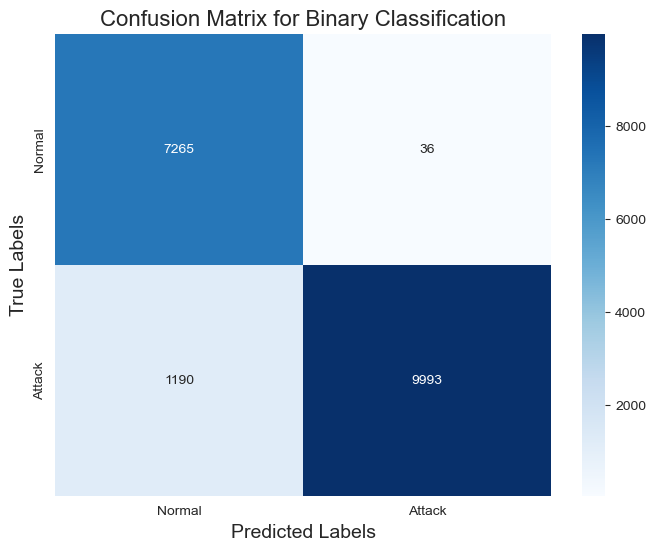

Multiclass Classification Report:
              precision    recall  f1-score   support

           0       0.84      1.00      0.91      7301
           1       1.00      1.00      1.00      2834
           2       0.95      0.56      0.70      1725
           3       1.00      1.00      1.00      5500
           4       0.78      0.31      0.45      1124

    accuracy                           0.92     18484
   macro avg       0.91      0.77      0.81     18484
weighted avg       0.92      0.92      0.90     18484



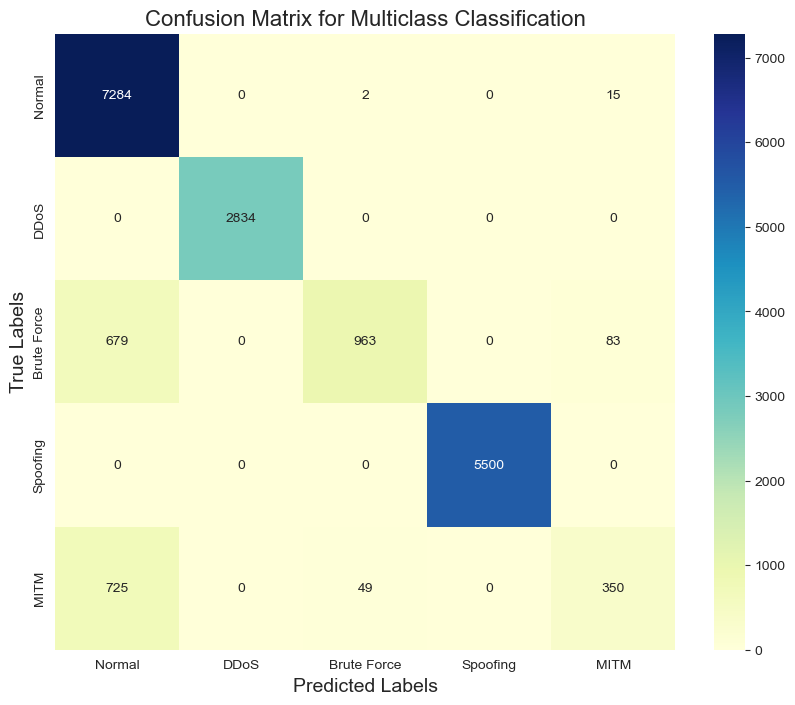

In [246]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

# Select features with moderate correlations
selected_features = ['packet_loss', 'latency (ms)', 'jitter (ms)', 'src_port', 'protocol','bandwidth_utilization (Mbps)',  'packet_loss']

# Create updated feature sets for Binary and Multiclass Classification
X_binary = df[selected_features]
X_multiclass = df[selected_features]

# Split data for binary classification
y_binary = df['Binary_Class']
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(
    X_binary, y_binary, test_size=0.2, random_state=42, stratify=y_binary
)

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train_bin, y_train_bin = smote.fit_resample(X_train_bin, y_train_bin)

# Train a binary classifier
binary_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(random_state=42, max_depth=10, n_estimators=50))
])
binary_pipeline.fit(X_train_bin, y_train_bin)

# Evaluate the binary classifier
y_pred_bin = binary_pipeline.predict(X_test_bin)
print("Binary Classification Report:")
print(classification_report(y_test_bin, y_pred_bin))

# Confusion Matrix for Binary Classification
conf_matrix_bin = confusion_matrix(y_test_bin, y_pred_bin)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_bin, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'])
plt.title('Confusion Matrix for Binary Classification', fontsize=16)
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.show()

# Split data for multiclass classification
y_multiclass = df['Attack_Type']
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(
    X_multiclass, y_multiclass, test_size=0.2, random_state=42, stratify=y_multiclass
)

# Train a multiclass classifier
multiclass_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(random_state=42, max_depth=10, n_estimators=50))
])
multiclass_pipeline.fit(X_train_multi, y_train_multi)

# Evaluate the multiclass classifier
y_pred_multi = multiclass_pipeline.predict(X_test_multi)
print("Multiclass Classification Report:")
print(classification_report(y_test_multi, y_pred_multi))

# Confusion Matrix for Multiclass Classification
conf_matrix_multi = confusion_matrix(y_test_multi, y_pred_multi)
target_names = ['Normal', 'DDoS', 'Brute Force', 'Spoofing', 'MITM']
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_multi, annot=True, fmt='d', cmap='YlGnBu', xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix for Multiclass Classification', fontsize=16)
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.show()



In [117]:
# 1. Cross-Validation for Robustness

from sklearn.model_selection import cross_val_score, StratifiedKFold

# Define cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Cross-validation for Binary Classifier (Stage 1)
binary_cv_scores = cross_val_score(grid_search, X, y_binary, cv=cv, scoring='accuracy')
print("Binary Classifier CV Accuracy:", binary_cv_scores)
print("Mean Binary Classifier CV Accuracy:", np.mean(binary_cv_scores))
print("Standard Deviation of Binary Classifier CV Accuracy:", np.std(binary_cv_scores))

# Cross-validation for Attack Classifier (Stage 2)
attack_cv_scores = cross_val_score(attack_classifier, X_attack, y_attack, cv=cv, scoring='accuracy')
print("Attack Type Classifier CV Accuracy:", attack_cv_scores)
print("Mean Attack Type Classifier CV Accuracy:", np.mean(attack_cv_scores))
print("Standard Deviation of Attack Type Classifier CV Accuracy:", np.std(attack_cv_scores))


Binary Classifier CV Accuracy: [1. 1. 1. 1. 1.]
Mean Binary Classifier CV Accuracy: 1.0
Standard Deviation of Binary Classifier CV Accuracy: 0.0
Attack Type Classifier CV Accuracy: [1.         1.         0.99991058 1.         1.        ]
Mean Attack Type Classifier CV Accuracy: 0.9999821157113477
Standard Deviation of Attack Type Classifier CV Accuracy: 3.5768577304828854e-05


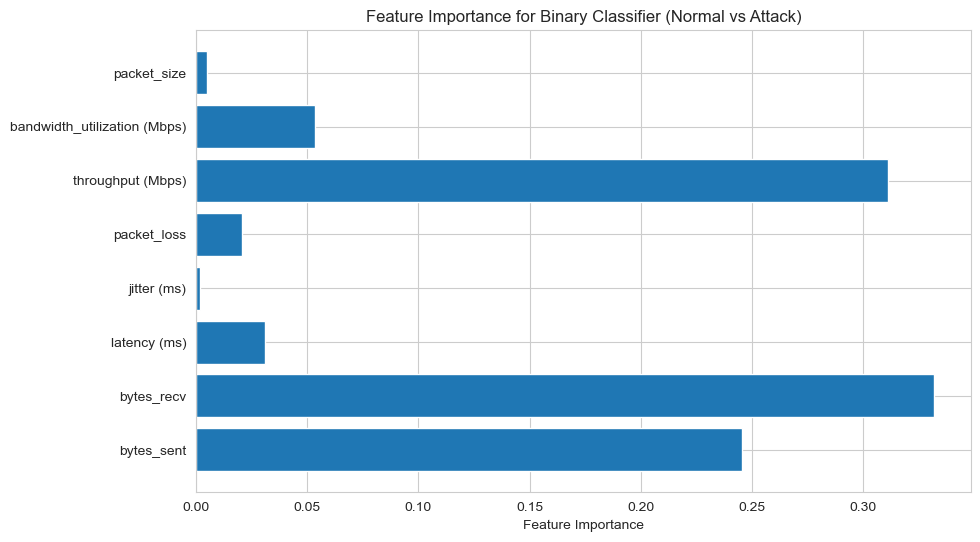

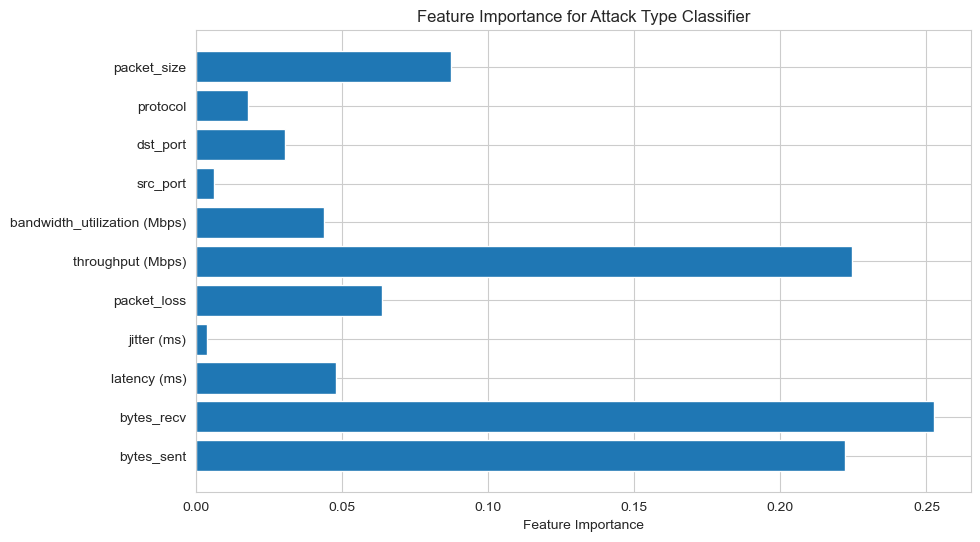

In [118]:
# 2. Feature Importance Analysis  
import matplotlib.pyplot as plt

# Feature importance for Binary Classifier
plt.figure(figsize=(10, 6))
plt.barh(X.columns, grid_search.feature_importances_)
plt.xlabel("Feature Importance")
plt.title("Feature Importance for Binary Classifier (Normal vs Attack)")
plt.show()

# Feature importance for Attack Type Classifier
plt.figure(figsize=(10, 6))
plt.barh(X_attack.columns, attack_classifier.feature_importances_)
plt.xlabel("Feature Importance")
plt.title("Feature Importance for Attack Type Classifier")
plt.show()


Binary Classification Accuracy: 0.9697576282190002
Binary Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.97      0.96      7301
           1       0.98      0.97      0.97     11183

    accuracy                           0.97     18484
   macro avg       0.97      0.97      0.97     18484
weighted avg       0.97      0.97      0.97     18484



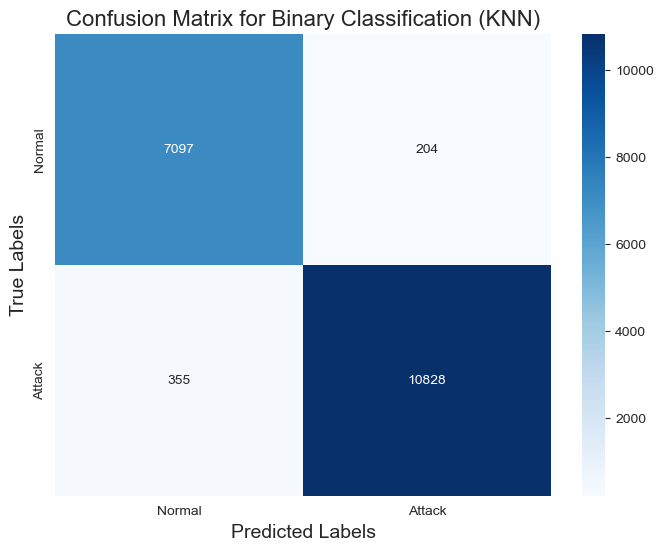

Multi-Class Classification Accuracy: 0.9447089374594244
Multi-Class Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.92      0.95      7301
           1       1.00      1.00      1.00      2834
           2       0.81      0.85      0.83      1725
           3       1.00      1.00      1.00      5500
           4       0.64      0.82      0.72      1124

    accuracy                           0.94     18484
   macro avg       0.89      0.92      0.90     18484
weighted avg       0.95      0.94      0.95     18484



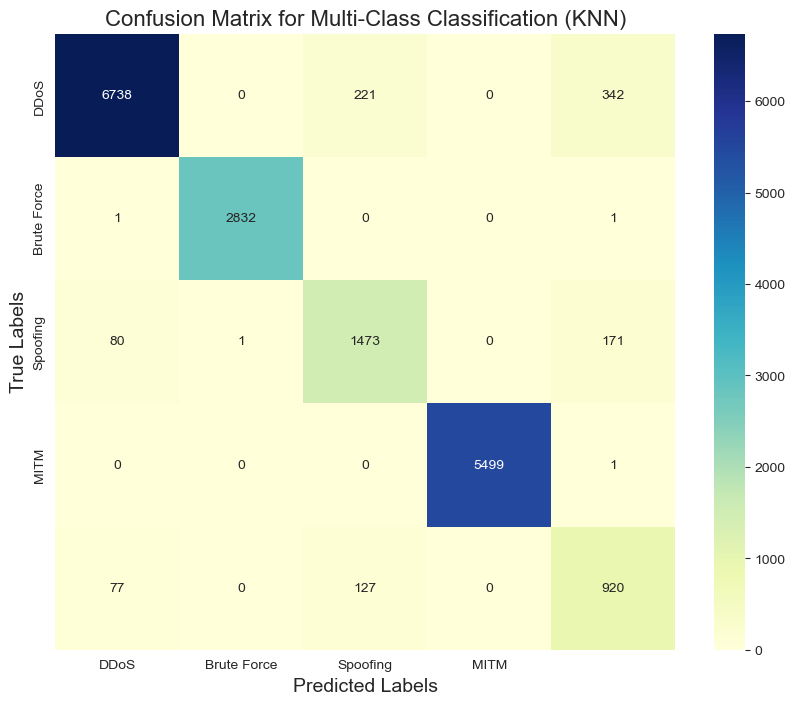

In [250]:

# Step 3: Train and Evaluate KNN for Binary Classification
knn_binary = KNeighborsClassifier(n_neighbors=5)  # Use k=5 (can be adjusted)
knn_binary.fit(X_train_bin, y_train_bin)

# Predictions
y_pred_bin = knn_binary.predict(X_test_bin)

# Evaluation
print("Binary Classification Accuracy:", accuracy_score(y_test_bin, y_pred_bin))
print("Binary Classification Report:\n", classification_report(y_test_bin, y_pred_bin))
conf_matrix_bin = confusion_matrix(y_test_bin, y_pred_bin)

# Visualize the Binary Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_bin, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'])
plt.title('Confusion Matrix for Binary Classification (KNN)', fontsize=16)
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.show()

# Step 4: Train-Test Split and Scaling for Multi-Class Classification
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(
    X_binary, y_multiclass, test_size=0.2, stratify=y_multiclass, random_state=42
)

# Handle class imbalance using SMOTE for multi-class classification
X_train_multi, y_train_multi = smote.fit_resample(X_train_multi, y_train_multi)

# Scale the features
X_train_multi = scaler.fit_transform(X_train_multi)
X_test_multi = scaler.transform(X_test_multi)

# Step 5: Train and Evaluate KNN for Multi-Class Classification
knn_multi = KNeighborsClassifier(n_neighbors=5)  # Use k=5 (can be adjusted)
knn_multi.fit(X_train_multi, y_train_multi)

# Predictions
y_pred_multi = knn_multi.predict(X_test_multi)

# Evaluation
print("Multi-Class Classification Accuracy:", accuracy_score(y_test_multi, y_pred_multi))
print("Multi-Class Classification Report:\n", classification_report(y_test_multi, y_pred_multi))
conf_matrix_multi = confusion_matrix(y_test_multi, y_pred_multi)

# Visualize the Multi-Class Confusion Matrix
target_names = ['DDoS', 'Brute Force', 'Spoofing', 'MITM']  # Update this based on your Attack_Type labels
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_multi, annot=True, fmt='d', cmap='YlGnBu', xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix for Multi-Class Classification (KNN)', fontsize=16)
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.show()


In [119]:
# 3. Hyperparameter Tuning


from sklearn.model_selection import RandomizedSearchCV

# Define parameter grid for Binary Classifier
param_grid_rf = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Hyperparameter tuning for Binary Classifier
random_search_rf = RandomizedSearchCV(grid_search, param_distributions=param_grid_rf, n_iter=10, cv=5, scoring='accuracy', random_state=42)
random_search_rf.fit(X, y_binary)
print("Best parameters for Binary Classifier:", random_search_rf.best_params_)
print("Best cross-validated score for Binary Classifier:", random_search_rf.best_score_)

# Define parameter grid for Attack Type Classifier
param_grid_attack = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Hyperparameter tuning for Attack Type Classifier
random_search_attack = RandomizedSearchCV(attack_classifier, param_distributions=param_grid_attack, n_iter=10, cv=5, scoring='accuracy', random_state=42)
random_search_attack.fit(X_attack, y_attack)
print("Best parameters for Attack Type Classifier:", random_search_attack.best_params_)
print("Best cross-validated score for Attack Type Classifier:", random_search_attack.best_score_)



Best parameters for Binary Classifier: {'n_estimators': 150, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 15}
Best cross-validated score for Binary Classifier: 1.0
Best parameters for Attack Type Classifier: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 5}
Best cross-validated score for Attack Type Classifier: 0.9909684326311465


In [120]:
# 3. Hyperparameter Tuning


from sklearn.model_selection import RandomizedSearchCV

# Define parameter grid for Binary Classifier
param_grid_rf = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Hyperparameter tuning for Binary Classifier
random_search_rf = RandomizedSearchCV(grid_search, param_distributions=param_grid_rf, n_iter=10, cv=5, scoring='accuracy', random_state=42)
random_search_rf.fit(X, y_binary)
print("Best parameters for Binary Classifier:", random_search_rf.best_params_)
print("Best cross-validated score for Binary Classifier:", random_search_rf.best_score_)

# Define parameter grid for Attack Type Classifier
param_grid_attack = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Hyperparameter tuning for Attack Type Classifier
random_search_attack = RandomizedSearchCV(attack_classifier, param_distributions=param_grid_attack, n_iter=10, cv=5, scoring='accuracy', random_state=42)
random_search_attack.fit(X_attack, y_attack)
print("Best parameters for Attack Type Classifier:", random_search_attack.best_params_)
print("Best cross-validated score for Attack Type Classifier:", random_search_attack.best_score_)




Best parameters for Binary Classifier: {'n_estimators': 150, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 15}
Best cross-validated score for Binary Classifier: 1.0
Best parameters for Attack Type Classifier: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 5}
Best cross-validated score for Attack Type Classifier: 0.9909684326311465


In [ ]:
import joblib

# Save the models


joblib.dump(grid_search, "binary_classifier_model2.joblib")
print("Saved binary_classifier_model2.joblib")

joblib.dump(attack_classifier, "attack_type_classifier_model2.joblib")
print("Saved attack_type_classifier_model2.joblib")


import os
print(os.getcwd())

